# ADA2017 project, milestone 2
# Data processing pipeline

In [104]:
# To use Spark 1.6.3 in Jupyter Notebook we have to use Python 3.4
!python --version

Python 3.4.5 :: Anaconda 4.3.1 (64-bit)


In [1]:
# USER to determine spark and dataset directories
import getpass
USER = getpass.getuser()
if USER == 'Tarmo':
    SPARK_DIR = 'C:/Users/Tarmo/Documents/Lausanne/CS-401_applied_data_analysis/spark/spark-1.6.3-bin-hadoop2.6'
    DATASET_DIR = 'C:/Users/Tarmo/Documents/Lausanne/data/Books_5.json'
    METADATA_DIR = 'C:/Users/Tarmo/Documents/Lausanne/data/meta_Books.json'
elif USER == 'adam':
    SPARK_DIR = '/home/adam/EPFL_courses/spark-1.6.3-bin-hadoop2.6'
    DATASET_DIR = '/media/adam/B236CB1D36CAE209/Studia/ADA/reviews_Books_5.json'
    METADATA_DIR = '/media/adam/B236CB1D36CAE209/Studia/ADA/meta_Books.json'
else:
    SPARK_DIR = '/home/adam/EPFL_courses/spark-1.6.3-bin-hadoop2.6'

In [ ]:
SPARK_DIR

### Import libraries
#### Spark libraries

In [106]:
import findspark
findspark.init(SPARK_DIR)

import pyspark
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SQLContext
from pyspark.sql.functions import to_date, unix_timestamp, from_unixtime  #to_timestamp, pyspark 2.2 functiona 

#### The others

In [2]:
import pandas as pd
from scipy import stats
import numpy as np
import json
import re
import json 
import gzip
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Collection and aggregation of data
Loading and processing the data to see what it contains. To make further processing faster, we create intermediate well-structured csv files to avoid having to process the JSON data files every time we want to look at the data. We take a look at several different metrics and their aggregates in the data (review length, review number; by day, by month, by year, by book, etc.)

### Initialization of Spark and SQL context

In [107]:
sc = SparkContext()
sqlContext = SQLContext(sc)

sc.version

'1.6.3'

### Loading of dataset and metadata

In [108]:
# Load the dataset and create RDDs
text_file = sc.textFile(DATASET_DIR)
# Convert previously read text file to json DataFrame
df = sqlContext.read.json(text_file)

# Load metadata for dataset and convert it to DataFrame
metadata = sc.textFile(METADATA_DIR)
metadata_df = sqlContext.read.json(metadata)

# Register DataFrames as tables to use those names in SQL-type queries
sqlContext.registerDataFrameAsTable(metadata_df, "metadata")
sqlContext.registerDataFrameAsTable(df, "dataset")

In [109]:
# Number of RDDs
text_file.getNumPartitions()

282

In [110]:
# Number of records in the dataset
text_file.count()

8898041

In [111]:
# Schema of the dataset
df.printSchema()

root
 |-- asin: string (nullable = true)
 |-- helpful: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- overall: double (nullable = true)
 |-- reviewText: string (nullable = true)
 |-- reviewTime: string (nullable = true)
 |-- reviewerID: string (nullable = true)
 |-- reviewerName: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- unixReviewTime: long (nullable = true)



### Initial data processing

In [112]:
# Bunch of castings, reviewTime: string->date, unixReviewTime: int->timestamp
# We do this to be able to better filter and manipulate the data
df = df.withColumn('unixReviewTime', from_unixtime(df['unixReviewTime']))
df = df.withColumn('reviewTime', to_date(df['unixReviewTime']))
df = df.withColumn('unixReviewTime', df['unixReviewTime'].cast('timestamp'))
df.printSchema()

root
 |-- asin: string (nullable = true)
 |-- helpful: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- overall: double (nullable = true)
 |-- reviewText: string (nullable = true)
 |-- reviewTime: date (nullable = true)
 |-- reviewerID: string (nullable = true)
 |-- reviewerName: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- unixReviewTime: timestamp (nullable = true)



In [113]:
# Look at couple of records, just to be sure that we obtained what we wanted
df.select("reviewTime", 'reviewText', 'unixReviewTime').take(2)

[Row(reviewTime=datetime.date(2012, 12, 16), reviewText='Spiritually and mentally inspiring! A book that allows you to question your morals and will help you discover who you really are!', unixReviewTime=datetime.datetime(2012, 12, 16, 1, 0)),
 Row(reviewTime=datetime.date(2003, 12, 11), reviewText="This is one my must have books. It is a masterpiece of spirituality. I'll be the first to admit, its literary quality isn't much. It is rather simplistically written, but the message behind it is so powerful that you have to read it. It will take you to enlightenment.", unixReviewTime=datetime.datetime(2003, 12, 11, 1, 0))]

### Average length of reviews per day

In [ ]:
# Computing an average length of review per day
aTuple = (0, 0)
avg = df.select("reviewTime", 'reviewText').rdd.map(lambda row: (row.reviewTime, len(row.reviewText)))
avg = avg.aggregateByKey(aTuple, lambda a,b: (a[0] + b, a[1] + 1), lambda a,b: (a[0] + b[0], a[1] + b[1]))
avg = avg.mapValues(lambda v: v[0]/v[1])
avg = avg.collect()

In [ ]:
# Processing acquired data using Pandas
avg_len = pd.DataFrame(avg, columns=['Date', 'Avg_length'])
avg_len['Date'] = pd.to_datetime(avg_len['Date'])
avg_len.set_index('Date', inplace=True)
avg_len.sort_index(inplace=True)
avg_len.head()

In [ ]:
# Save to file not to compute this one more time
avg_len.to_csv("avg_length_review_by_day.csv")

In [6]:
avg_len = pd.read_csv("avg_length_review_by_day.csv", index_col='Date', parse_dates=['Date'])
avg_len.head()

,Avg_length
Date,
1996-05-20,1752.0
1996-06-25,1123.0
1996-08-17,826.0
1996-09-18,897.0
1996-11-15,1757.0


### Average length of reviews per month

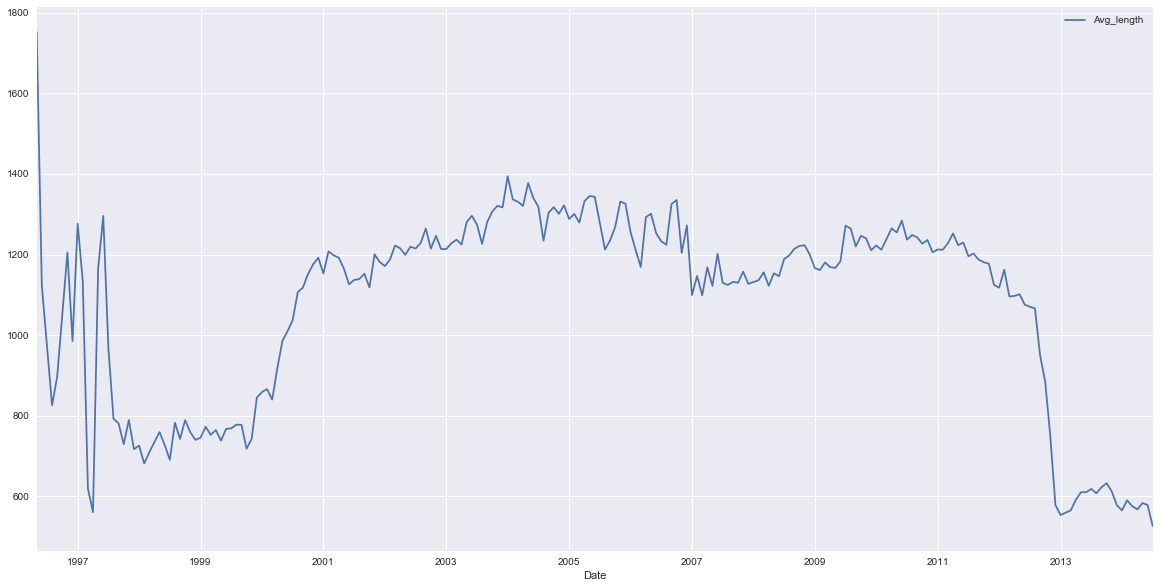

In [115]:
monthly_data = avg_len.groupby(avg_len.index.to_period('M')).mean()
monthly_data.plot(figsize=(20,10))

We notice that the average review length per month appears to have three somewhat stable levels in time: before 2000, between 2000 and 2013 and after 2013. In the middle period the review length is consistently high, and crashes around 2012-2013. In the beginning of the dataset time period, the number of reviews is small so there is high variation in monthly average.

### Average length of reviews between 2012 and 2013

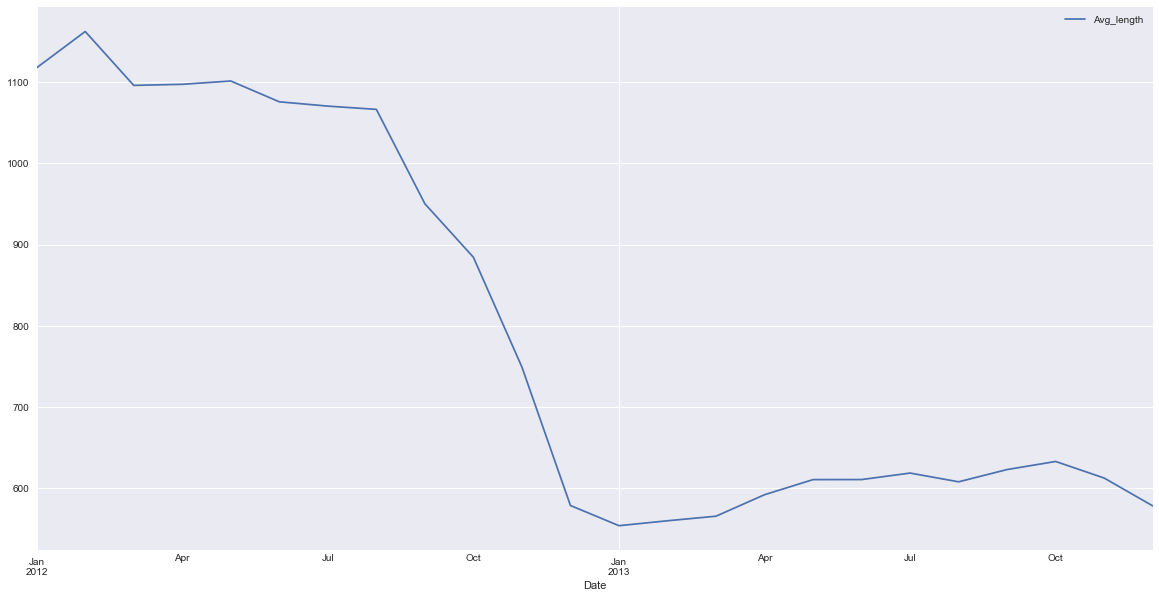

In [116]:
monthly_data['2012':'2013'].plot(figsize=(20,10))

The extreme drop is located between August 2012 and January 2013.

In [ ]:
# Save processed data
monthly_data.to_csv("avg_length_review_by_month.csv")

In [ ]:
# (Successful) attempt to filter by timestamp 
tmp = df.rdd.filter(lambda row: row.unixReviewTime > pd.to_datetime('2012-05')
                     and row.unixReviewTime < pd.to_datetime('2013'))
tmp.take(5)

### Number of reviews per each day

In [ ]:
# Number of reviews per each day
number_of_reviews = df.rdd.map(lambda row: (row.reviewTime, 1)).reduceByKey(lambda a, b: a+b).collect()

In [ ]:
# Processing the data
rev_num = pd.DataFrame(number_of_reviews, columns=['Date', 'Number of reviews'])
rev_num['Date'] = pd.to_datetime(rev_num['Date'])
rev_num.set_index('Date', inplace=True)
rev_num.sort_index(inplace=True)
rev_num.head()

In [ ]:
# Save the data not to compute over and over
rev_num.to_csv("number_of_reviews_per_day.csv")

In [9]:
# Read file with the data
rev_num = pd.read_csv("number_of_reviews_per_day.csv", index_col='Date', parse_dates=['Date'])
rev_num.tail()

,Number of reviews
Date,
2014-07-19,2797
2014-07-20,3332
2014-07-21,3456
2014-07-22,2697
2014-07-23,619


### Number of reviews per month

In [ ]:
monthly_data_reviews = rev_num.groupby(rev_num.index.to_period('M')).sum()
# Save the processed data
monthly_data_reviews.to_csv("number_of_reviews_per_month.csv")

In [85]:
# Read file with the data
monthly_data_reviews = pd.read_csv("number_of_reviews_per_month.csv", index_col='Date', parse_dates=['Date'])

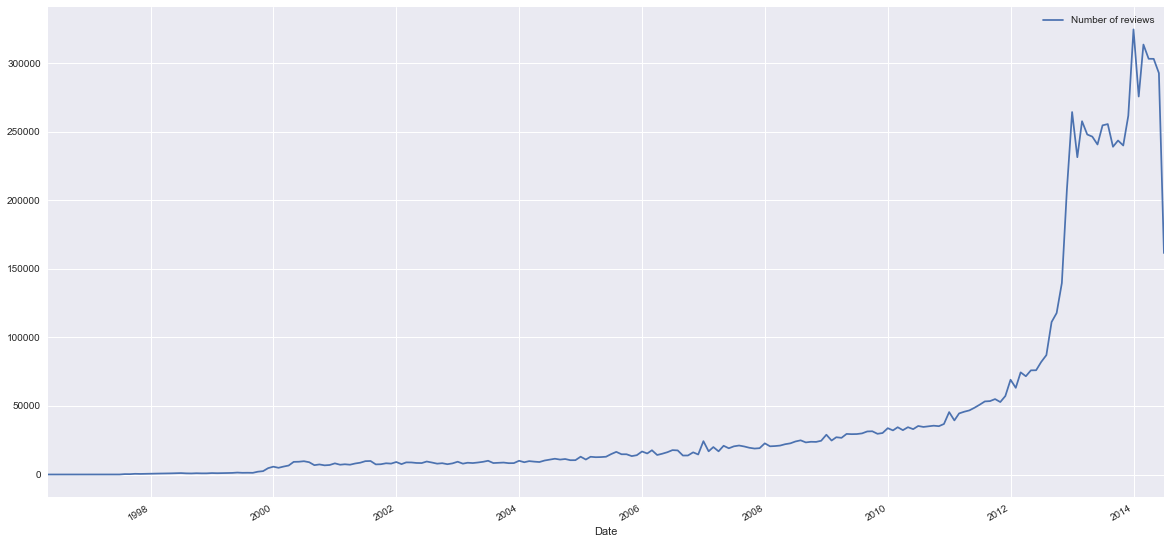

In [86]:
monthly_data_reviews.plot(figsize=(20,10))

We see that in the beginning of the data period, there are hardly any reviews being written. The number of reviews increases consistently until there is a huge jump after 2012. The extreme increase coincides with the drop in the average review length, and may reflect a sudden change in reviewer numbers and/or behavior. The apparent increase might also be due to changes in Amazon review policies: after a significant change, Amazon might retroactively remove old reviews not conforming to the new policy.

### Number of reviews per book

In [ ]:
number_of_reviews_per_book = df.rdd.map(lambda row: (row.asin, 1)).reduceByKey(lambda a, b: a+b).collect()
len(number_of_reviews_per_book)

In [ ]:
# Processing the data using Pandas and saving it to csv file
df_number_of_reviews_per_book = pd.DataFrame(number_of_reviews_per_book, columns=['Book_id', 'Number of reviews'])
df_number_of_reviews_per_book.sort_values('Number of reviews', ascending=False, inplace = True)
df_number_of_reviews_per_book.to_csv("number_of_reviews_per_book.csv", index=False)
df_number_of_reviews_per_book.head(10)

In [120]:
# Read file with the data
df_number_of_reviews_per_book = pd.read_csv("number_of_reviews_per_book.csv", index_col='Book_id')

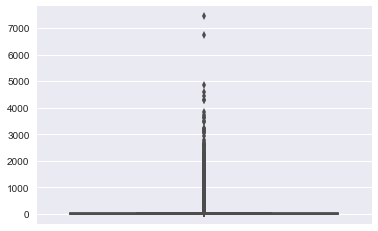

In [129]:
# Boxplot of numbers of reviews
sns.boxplot(np.array(df_number_of_reviews_per_book['Number of reviews'].values), orient='v')

The boxplot is not very box-like, since most books have only a small number of reviews.

We look at the numbers without the outliers:

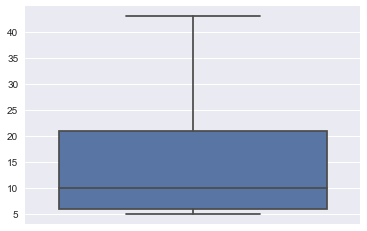

In [130]:
sns.boxplot(np.array(df_number_of_reviews_per_book['Number of reviews'].values), orient='v', showfliers=False)

In [131]:
# Basic statistics for this variable
stats.describe(df_number_of_reviews_per_book['Number of reviews'].values)

DescribeResult(nobs=367982, minmax=(5, 7440), mean=24.180641987923323, variance=4396.0938613274502, skewness=25.747403776095645, kurtosis=1461.9790549248125)

## Top 30 books based on the number of reviews
Our time-independent popularity metric is the number of reviews, so we take a closer look at the top 30 books according to it.

In [ ]:
top_books = df.rdd.map(lambda row: (row.asin, 1)).reduceByKey(lambda a, b: a+b).sortBy(lambda wc: -wc[1]).take(30)

top_books_df = sqlContext.createDataFrame(top_books, ['asin', 'rew_num'])
sqlContext.registerDataFrameAsTable(top_books_df, "top_books")
top_books_df.take(5)

In [ ]:
# Join the dataset table with the metadata table to see titles of the most popular books
sqlContext.sql("select t.asin, m.title from metadata m join top_books t on m.asin=t.asin").collect()

In [ ]:
sqlContext.sql("select t.asin, m.title from metadata m join top_books t limit 10").collect()

### Two methods of filtering by ids of books

In [ ]:
most_reviewed_books_id_top = df_number_of_reviews_per_book[:30]
most_reviewed_top = df.rdd.filter(lambda row: row.asin in list(most_reviewed_books_id_top.Book_id))
            .map(lambda row: (row.asin, row.reviewTime)).collect()

In [ ]:
most_reviewed_top_2 = sqlContext.sql("select asin, reviewTime from dataset where asin in " + 
               str(tuple(most_reviewed_books_id_top.Book_id)))

### Processing the data for top30 books

In [ ]:
# Processing the data using Pandas
most_reviewed_books_top30_df = pd.DataFrame(most_reviewed_top, columns=['asin', 'reviewTime'])
# Convert to datetime type
most_reviewed_books_top30_df['reviewTime'] = pd.to_datetime(most_reviewed_books_top30_df['reviewTime'])
# Assign number of review to compute the sum
most_reviewed_books_top30_df['Number_of_reviews'] = 1
# Create monthly period for aggregation purpose
most_reviewed_books_top30_df['Year-month'] = most_reviewed_books_top30_df['reviewTime'].dt.to_period('M')
most_reviewed_books_top30_df.head()

In [ ]:
# Save data describing number of reviews per day for each book in top30
most_reviewed_books_top30_df.groupby(['asin', 'reviewTime']).sum()
                            .to_csv("number_of_reviews_per_day_top30_books.csv")

In [ ]:
# Aggregating the data by month
m_rev_books_by_month = most_reviewed_books_top30_df.groupby(['asin', 'Year-month'], as_index=True).sum()
m_rev_books_by_month.to_csv("number_of_reviews_per_month_top30_books.csv")

In [133]:
m_rev_books_by_month = pd.read_csv("number_of_reviews_per_month_top30_books.csv").set_index(['asin', 'Year-month'])

### Multi-line plot for top30 books - timeseries of reviews per month

In [ ]:
m_rev_books_by_month.unstack(level=0).to_csv("number_of_reviews_per_month_top30_books_UNSTACKED.csv")

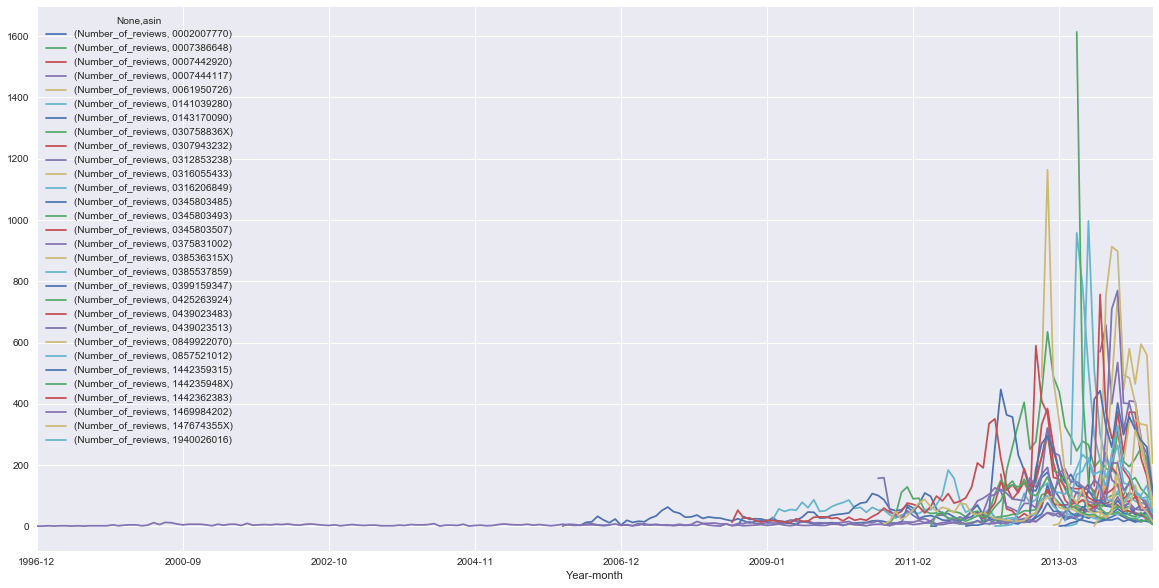

In [134]:
m_rev_books_by_month.unstack(level=0).plot(figsize = (20,10))

We see that for the top 30 books, most reviews are made after January 2013.

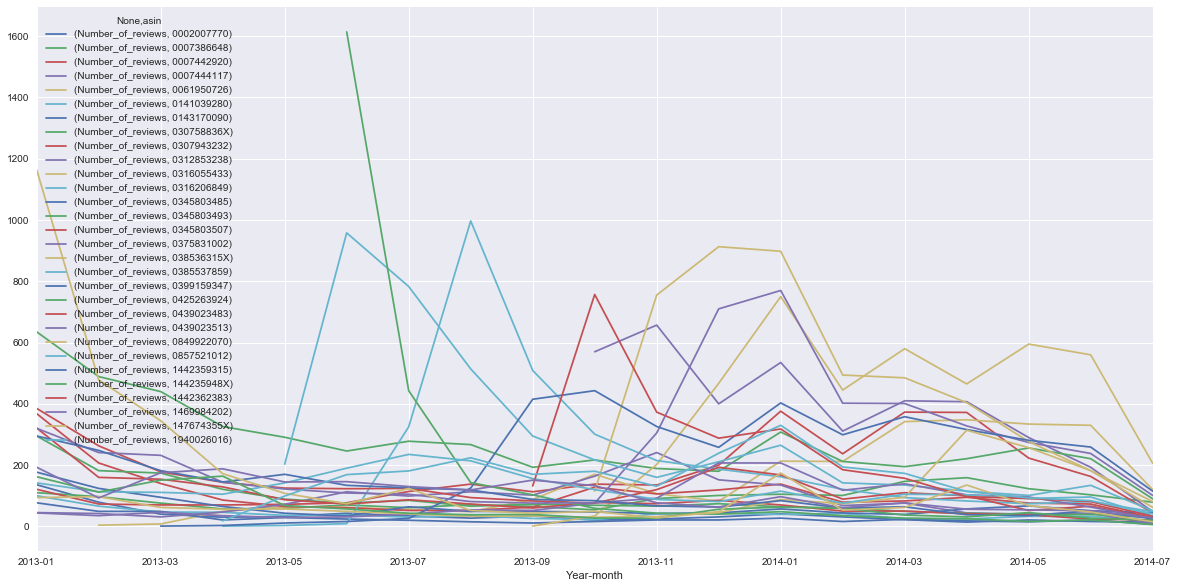

In [135]:
m_rev_books_by_month.unstack(level=0)['2013':].plot(figsize = (20,10))

A top 30 book accrues a lot of reviews right after publication (or rather, appearance of first review). It is highly book-dependent whether this rate of reviewing drops quickly or slowly.

### Average length and number of reviews per book

In [ ]:
aTuple = (0, 0)
avg_len_review = df.select('asin', 'reviewText').rdd.map(lambda row: (row.asin, len(row.reviewText)))
avg_len_review = avg_len_review.aggregateByKey(aTuple, lambda a,b: (a[0] + b, a[1] + 1), lambda a,b: (a[0] + b[0], a[1] + b[1]))
avg_len_review = avg_len_review.mapValues(lambda v: (v[0]/v[1], v[1]))
avg_len_review = avg_len_review.collect()

In [ ]:
# Transformation of the data to be able to load it as a DataFrame 
avg_len_review = [(k, v1, v2) for k, (v1, v2) in avg_len_review]

In [ ]:
# Processing and saving to file
avg_len_review_per_book_df = pd.DataFrame(avg_len_review, columns=['Book_id', 'Avg_len', 'number_of_reviews'])
avg_len_review_per_book_df.sort_values(['Avg_len', 'number_of_reviews'], ascending=False, inplace=True)
avg_len_review_per_book_df.to_csv("avg_length_and_number_of_reviews_per_book.csv", index=False)
avg_len_review_per_book_df.head(10)

In [13]:
avg_len_review_per_book_df = pd.read_csv("avg_length_and_number_of_reviews_per_book.csv",index_col="Book_id")
avg_len_review_per_book_df.head()

,Avg_len,number_of_reviews
Book_id,,
0195396170,13459.5,6
0700619542,9934.8,5
0061312118,9511.1,10
0875522645,9377.8,5
1405159286,8716.0,9


## Ratings
### Collecting the data about ratings
Each row contains: book serial number, date of the review, rating (overall). We construct an intermediate file where each book (asin) is associated with five column features, which give the number of ratings from 1 to 5, respectively.

Rating is in stars (integers), from 1 to 5.

In [ ]:
ratings = df.select("asin", "reviewTime", "overall").rdd.map(lambda row: (row.asin, row.reviewTime, int(row.overall))).collect()

In [ ]:
ratings_df = pd.DataFrame(ratings, columns=['asin', 'Date', 'rating'])
ratings_df['Date'] = pd.to_datetime(ratings_df['Date'])
ratings_df.shape

In [ ]:
# Save the data
ratings_df.to_csv("ratings.csv", index=False)

In [ ]:
# Aggregate data by number of each 1, 2, 3, 4, 5 ratings

ratings_grouped_df = ratings_df.groupby(['asin', 'rating']).count()
ratings_grouped_unstack_df = ratings_grouped_df.unstack(level=1, fill_value=0)
ratings_grouped_unstack_df.columns = ratings_grouped_unstack_df.columns.droplevel()
ratings_grouped_unstack_df.to_csv("ratings_grouped_unstack.csv")
ratings_grouped_unstack_df.head()

In [5]:
ratings_grouped_unstack_df = pd.read_csv('ratings_grouped_unstack.csv', index_col='asin')
ratings_grouped_unstack_df.head()

,1,2,3,4,5
asin,,,,,
000100039X,6,4,8,15,173
0001055178,0,4,2,10,2
0001473123,1,0,0,2,13
0001473727,0,0,0,0,7
0001473905,0,0,1,0,5


Column 1 contains the number of 1-star ratings, etc.

In [11]:
ratings_grouped_unstack_df.rename(columns={1:"1", 2:"2", 3:"3", 4:"4", 5:"5"}, inplace=True)

# Data analysis

By the previous look at the data, we drew the conclusion that we would focus on the negative and positive ratings. We will therefore, for now, focus on the file giving the number of 1,2,3,4 and 5 stars ratings for each book. 

In [16]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
#create a dataframe with the ratings for each books and the length and total number or reviews
reviews_df_raw=pd.DataFrame.from_csv('ratings_grouped_unstack.csv')
d1=pd.DataFrame.from_csv('avg_length_and_number_of_reviews_per_book.csv')

In [18]:
reviews_df_raw.head()

,1,2,3,4,5
asin,,,,,
000100039X,6,4,8,15,173
0001055178,0,4,2,10,2
0001473123,1,0,0,2,13
0001473727,0,0,0,0,7
0001473905,0,0,1,0,5


In this dataset, asin is the Amazon identifier for the book, and the column named 1 (respectively 2, 3, 4 and 5) corresponds to how many reviews were associated with a rating of 1 star (respectively 2, 3, 4 and 5 stars) (every time someone reviews a book they need to rate the book from 1 star to 5). 


We can start by plotting the total number of ratings for each number of stars.

([<matplotlib.axis.XTick at 0x15d2e588>,
 <a list of 5 Text xticklabel objects>)

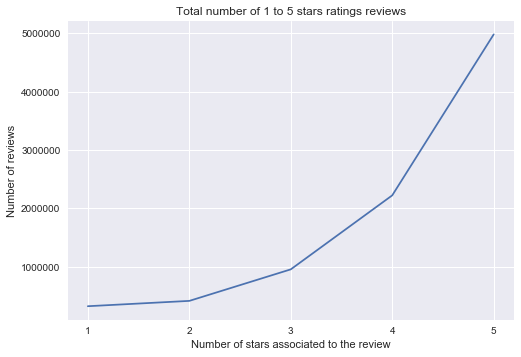

In [19]:
x = reviews_df_raw.columns
y = reviews_df_raw.sum()

plt.plot(x,y)
plt.title('Total number of 1 to 5 stars ratings reviews')
plt.ylabel('Number of reviews')
plt.xlabel('Number of stars associated to the review')
plt.xticks([1,2,3,4,5])

Let's try to plot the logarithm of y for this plot to see if we can find something interesting.

([<matplotlib.axis.XTick at 0x9e0efd0>,
 <a list of 5 Text xticklabel objects>)

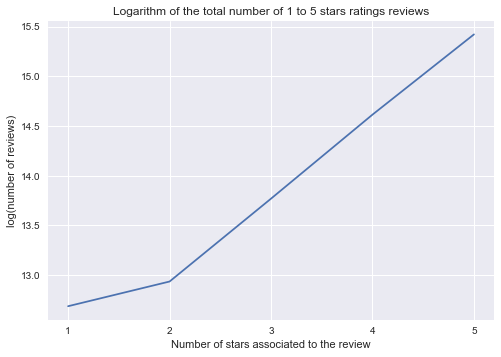

In [20]:
y2=np.log(y)
g=plt.plot(x,y2)

plt.title('Logarithm of the total number of 1 to 5 stars ratings reviews')
plt.ylabel('log(number of reviews)')
plt.xlabel('Number of stars associated to the review')
plt.xticks([1,2,3,4,5])

From 2 to 5 stars the logarithm of y gives a straight line! This means that people would give exponentially more 5 stars than 2 stars rating. This is a very interesting discovery that will be needed to be questionned further, by, for example, checking if in the Amazon rules concerning reviews something could explain this. 


#### We will now try to find "good books" , "controversial books" and "bad books" defined as follow:
* "good book"= many high ratings hew low ratings 
* "bad book" = many low ratings few high ratings  
* "controversial book" = any kind of ratings with small variance between number of reviews with 1,2,3,4 or 5 stars 


In [21]:
# merge the two datasets and calculate the "bad ratio" and "good_ratio" for each book
#bad_ratio and good_ratio are defined as the number of 1,2 stars (resp 4,5 stars) divided 
#by the total number of reviews 

d1['asin']=d1.index
reviews_df_raw['asin']=reviews_df_raw.index
reviews_df_tot=pd.merge(reviews_df_raw, d1, on=['asin'])
reviews_df_tot['bad_ratio']= (reviews_df_tot['1']+reviews_df_tot['2'])/(reviews_df_tot['1']+reviews_df_tot['2']+reviews_df_tot['3']+reviews_df_tot['4']+reviews_df_tot['5'])
reviews_df_tot['good_ratio']= (reviews_df_tot['4']+reviews_df_tot['5'])/(reviews_df_tot['1']+reviews_df_tot['2']+reviews_df_tot['3']+reviews_df_tot['4']+reviews_df_tot['5'])


reviews_df_tot.head()

,1,2,3,4,5,asin,Avg_len,number_of_reviews,bad_ratio,good_ratio
0,6,4,8,15,173,000100039X,638.033981,206,0.048544,0.912621
1,0,4,2,10,2,0001055178,1308.611111,18,0.222222,0.666667
2,1,0,0,2,13,0001473123,287.937500,16,0.062500,0.937500
3,0,0,0,0,7,0001473727,187.571429,7,0.000000,1.000000
4,0,0,1,0,5,0001473905,481.833333,6,0.000000,0.833333


For our analysis to make sense, we need to take books that have a significative number of reviews as if the book only has one or two reviews that is negative/positive, the book will be directly classified as a bad/good book and this is not reliable. However, if we take a minimum too high for the number of reviews of a book, we will have very few "bad books" as, we will see that the bulk of bad books have very few comments. 

We will try with a limit of 10 reviews. 

In [22]:
reviews_df = reviews_df_tot.copy()[reviews_df_tot.number_of_reviews>10]

In [23]:
# as a first guess, we can define bad books as having a bad ratio higher than 0.7 
#(respectively lower than 0.7 for good books)


#we will compare how many bad books we have if we consider the all dataset and if we consider only the books that have more than 10 reviews (for reliability)
bad_books_tot = reviews_df_tot[reviews_df_tot.bad_ratio>0.7]
bad_books = reviews_df[reviews_df.bad_ratio>0.7]

#As we have already a significant number of good and controversial books with our limit, we just consider with the limit 
good_books = reviews_df[reviews_df.good_ratio>0.7]
controversial_books= reviews_df[abs(reviews_df.good_ratio-reviews_df.bad_ratio)<0.1]



In [24]:
bad_books_tot.describe()

,1,2,3,4,5,Avg_len,number_of_reviews,bad_ratio,good_ratio
count,936.000000,936.000000,936.000000,936.000000,936.000000,936.000000,936.000000,936.000000,936.000000
mean,5.973291,1.967949,0.591880,0.475427,0.849359,852.246335,9.857906,0.816833,0.123201
std,16.132484,2.010411,1.105213,0.930433,4.037758,577.108054,21.163739,0.085686,0.095057
min,0.000000,0.000000,0.000000,0.000000,0.000000,116.666667,5.000000,0.704545,0.000000
25%,3.000000,1.000000,0.000000,0.000000,0.000000,449.900000,5.000000,0.750000,0.000000
50%,4.000000,2.000000,0.000000,0.000000,0.000000,710.778333,7.000000,0.800000,0.142857
75%,6.000000,3.000000,1.000000,1.000000,1.000000,1128.700000,9.000000,0.843117,0.200000
max,447.000000,20.000000,14.000000,12.000000,119.000000,6498.200000,582.000000,1.000000,0.294118


In [25]:
bad_books.describe()

,1,2,3,4,5,Avg_len,number_of_reviews,bad_ratio,good_ratio
count,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000
mean,15.794595,3.372973,1.502703,1.140541,2.405405,842.318764,24.216216,0.796491,0.134620
std,34.482998,3.216183,1.981228,1.671933,8.847929,440.475755,44.836257,0.077958,0.076236
min,2.000000,0.000000,0.000000,0.000000,0.000000,147.909091,11.000000,0.704545,0.000000
25%,7.000000,1.000000,0.000000,0.000000,0.000000,539.714286,12.000000,0.733333,0.076923
50%,10.000000,3.000000,1.000000,1.000000,1.000000,768.315789,15.000000,0.777070,0.138889
75%,16.000000,5.000000,2.000000,2.000000,2.000000,1090.764706,21.000000,0.833333,0.187500
max,447.000000,20.000000,14.000000,12.000000,119.000000,2494.909091,582.000000,1.000000,0.294118


As we said before, the number of 'bad books' depends a lot on the limit we take for the minimum number of reviews of our dataset. This might be due to the fact that when books have some bad comments, the books popularity drops and people stop reviewing them very fast. 

In [26]:
good_books.describe()

,1,2,3,4,5,Avg_len,number_of_reviews,bad_ratio,good_ratio
count,142711.000000,142711.000000,142711.000000,142711.000000,142711.000000,142711.000000,142711.000000,142711.000000,142711.000000
mean,0.954432,1.410024,3.788601,10.963324,26.448417,847.175892,43.564799,0.049209,0.870685
std,3.312660,3.970387,9.158551,22.480132,59.200941,491.345135,92.935312,0.053780,0.084861
min,0.000000,0.000000,0.000000,0.000000,0.000000,121.909091,11.000000,0.000000,0.700315
25%,0.000000,0.000000,1.000000,3.000000,9.000000,464.714286,14.000000,0.000000,0.806452
50%,0.000000,0.000000,2.000000,6.000000,13.000000,749.948718,22.000000,0.038462,0.875000
75%,1.000000,1.000000,4.000000,11.000000,25.000000,1117.581144,40.000000,0.080000,0.934783
max,229.000000,298.000000,607.000000,1271.000000,4839.000000,5850.666667,6717.000000,0.296296,1.000000


In [27]:
controversial_books.describe()

,1,2,3,4,5,Avg_len,number_of_reviews,bad_ratio,good_ratio
count,2810.000000,2810.000000,2810.000000,2810.000000,2810.000000,2810.000000,2810.000000,2810.000000,2810.000000
mean,6.190747,5.680783,6.414591,5.698221,6.730961,972.133560,30.715302,0.385675,0.402699
std,12.073168,10.577229,11.582232,12.215638,13.130457,554.989698,57.239637,0.066117,0.063787
min,0.000000,0.000000,0.000000,0.000000,0.000000,136.357143,11.000000,0.090909,0.153846
25%,2.000000,2.000000,2.000000,2.000000,3.000000,553.401786,13.000000,0.347826,0.363636
50%,4.000000,4.000000,4.000000,3.000000,4.000000,908.617908,17.000000,0.384615,0.406250
75%,6.000000,6.000000,7.000000,6.000000,7.000000,1270.751786,30.000000,0.428571,0.454545
max,359.000000,373.000000,397.000000,464.000000,457.000000,4822.833333,2050.000000,0.545455,0.548387


We can already notice that there are way less "bad books" according to our definition and it is very dependent of the limit that we impose for the minimum reviews taken into account in our dataset. This needs to be analysed further. 

As there are many outliers in our dataset, we will plot only robust variables. The first function defined below plots boxplots with outliers and the second one without the outliers. 

In [28]:
def plot_categories(column):
    # Create a figure with 2 subplots and set the title
    fig, ax = plt.subplots(figsize=(15,12), ncols=1, nrows=3)
    plt.suptitle("Boxplots of "+ column + " for three categories of books", fontsize=18)


    # Adjust the sub plots parameters
    hspace =  0.5   

    plt.subplots_adjust(
      hspace  =  hspace
    )


    # Set a title to each graph
    ax[0].set_title("Bad books", fontsize=15)
    ax[1].set_title("Good books", fontsize=15)
    ax[2].set_title("Controversial Books", fontsize=15)

    # Plot the data

    sns.boxplot( bad_books[column], ax=ax[0])
    sns.boxplot( good_books[column], ax= ax[1])
    sns.boxplot( controversial_books[column], ax=ax[2])

    plt.show()

In [29]:
def plot_categories_no_outliers(column):
    # Create a figure with 2 subplots and set the title
    fig, ax = plt.subplots(figsize=(15,12), ncols=1, nrows=3)
    plt.suptitle("Boxplots of "+ column + " for three categories of books", fontsize=18)


    # Adjust the sub plots parameters
    hspace =  0.5   

    plt.subplots_adjust(
      hspace  =  hspace
    )


    # Set a title to each graph
    ax[0].set_title("Bad books", fontsize=15)
    ax[1].set_title("Good books", fontsize=15)
    ax[2].set_title("Controversial Books", fontsize=15)

    # Plot the data

    sns.boxplot( bad_books[column], ax=ax[0], showfliers=False)
    sns.boxplot( good_books[column], ax= ax[1], showfliers=False)
    sns.boxplot( controversial_books[column], ax=ax[2], showfliers=False)

    plt.show()

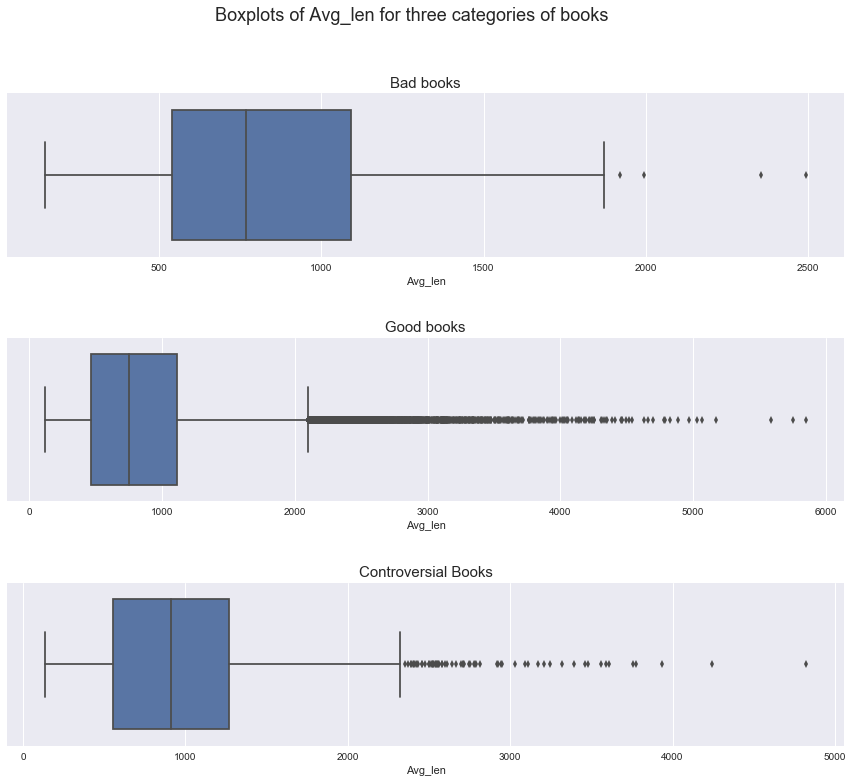

In [30]:
plot_categories('Avg_len')

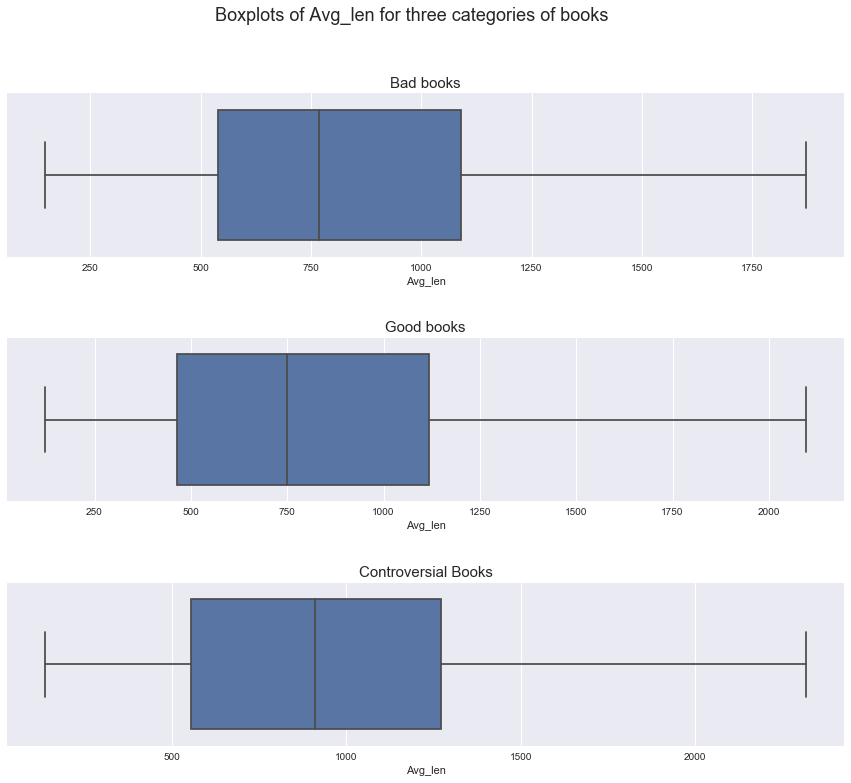

In [31]:
plot_categories_no_outliers('Avg_len')

The average length of the reviews is pretty well balanced through the groups. However, there are way more outliers (longer reviews) in the "good books" and "controversial books" than in the "bad books". The median for controversial books also seems to be a bit higher than for the two other categories. This could be explained by the fact that when people don't agree with each other they are more willing to write longer comments to explain their point of view. However, we see that we need to use more reliable statistics that the bad_ratio and good_ratio that we made up before to be able to draw conclusions. 

#### What we can do now is to try to refine our definitions for the books categories, and to do that we can try to consider mean and standard deviation of the ratings to have maybe more  interpretable results. 

We can calculate the mean and the standard deviation of ratings for each book. We can use these not robust statistics here as the ratings are bound between 1 and 5 so there are no outliers. 

In [32]:
# start again with a copy of our first dataset 
reviews_df_2 = reviews_df_tot.copy()
del reviews_df_2['bad_ratio']
del reviews_df_2['good_ratio']

reviews_df_2.head()

,1,2,3,4,5,asin,Avg_len,number_of_reviews
0,6,4,8,15,173,000100039X,638.033981,206
1,0,4,2,10,2,0001055178,1308.611111,18
2,1,0,0,2,13,0001473123,287.937500,16
3,0,0,0,0,7,0001473727,187.571429,7
4,0,0,1,0,5,0001473905,481.833333,6


In [33]:
# calculate the mean for each book 

reviews_df_2 ['mean_rat'] = (reviews_df_2['1']*1+reviews_df_2['2']*2+reviews_df_2['3']*3+reviews_df_2['4']*4+reviews_df_2['5']*5)/reviews_df_2.number_of_reviews
reviews_df_2.head()


,1,2,3,4,5,asin,Avg_len,number_of_reviews,mean_rat
0,6,4,8,15,173,000100039X,638.033981,206,4.674757
1,0,4,2,10,2,0001055178,1308.611111,18,3.555556
2,1,0,0,2,13,0001473123,287.937500,16,4.625000
3,0,0,0,0,7,0001473727,187.571429,7,5.000000
4,0,0,1,0,5,0001473905,481.833333,6,4.666667


([<matplotlib.axis.XTick at 0x152252e8>,
 <a list of 5 Text xticklabel objects>)

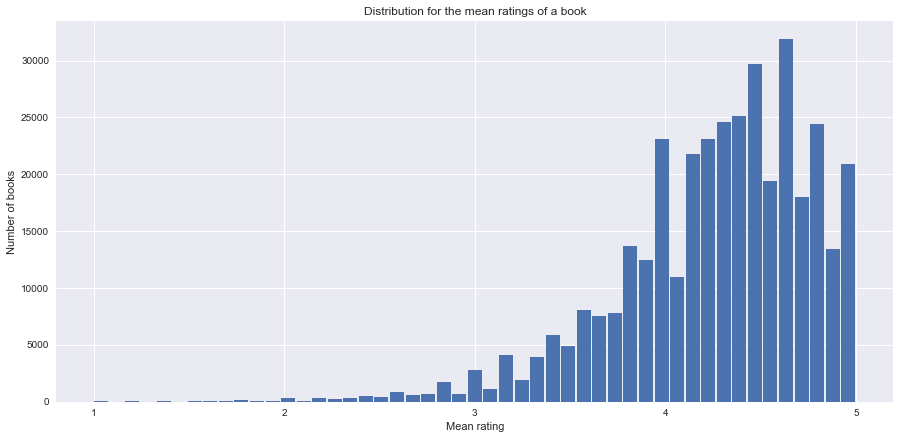

In [34]:
#Plot a histogram 
fig, ax = plt.subplots(figsize=(15,7), ncols=1, nrows=1)

reviews_df_2.mean_rat.hist(bins=np.linspace(1,5,50), rwidth=0.9)




plt.title('Distribution for the mean ratings of a book')
plt.xlabel('Mean rating')
plt.ylabel('Number of books')
plt.xticks([1,2,3,4,5])

We see that the distribution is completely left skewed and we will try to recentre it between 0 and 1 using this article http://rogeriofvieira.com/wp-content/uploads/2016/05/Data-Transformations-1.pdf.

From this article, we see that we can try two transformations: 

 - Logarithms : Growth rates are often exponential and log transforms will
often normalize them. Log transforms are particularly appropriate if the
variance increases with the mean.
 - Reciprocal : If a log transform does not normalize your data you could try a
reciprocal (1/x) transformation. This is often used for enzyme reaction rate
data. 


In [35]:
#Take the transformated weigthed mean as explained in the article 
reviews_df_2['Trans_weighted_mean'] = np.log10(6 - reviews_df_2['mean_rat'].values)

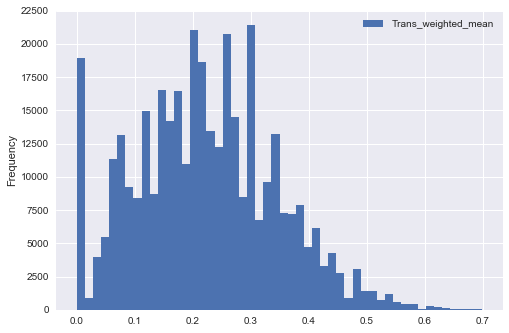

In [36]:
reviews_df_2.plot(y = 'Trans_weighted_mean', kind = 'hist', bins = 50, logx=False)

In [37]:
reviews_df_2['Inverse_weighted_mean'] = 1/(6 - reviews_df_2['mean_rat'].values)

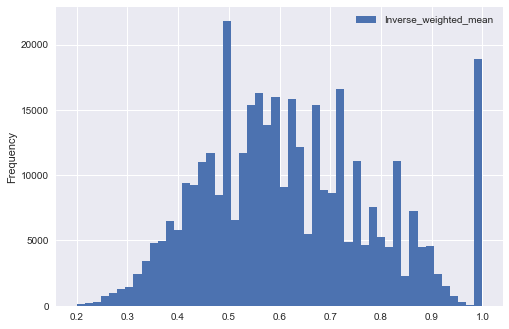

In [38]:
reviews_df_2.plot(y = 'Inverse_weighted_mean', kind = 'hist', bins = 50, logx=False)

We see that this doesn't give very smooth plots and this is due to the books that have just a few ratings and therefore will have values completely equal to 5 for example. As before, we will consider only books that have more than 10 reviews. 

In [39]:
reviews_df_sm = reviews_df_2.copy()[reviews_df_tot.number_of_reviews>10]

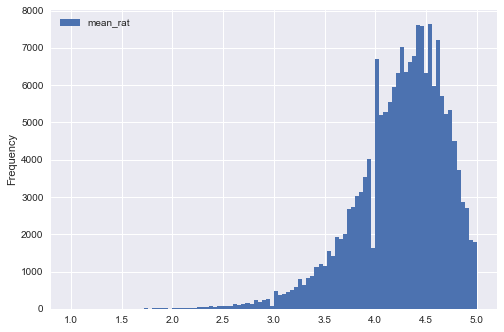

In [40]:
reviews_df_sm.plot(y = 'mean_rat', kind = 'hist', bins = 100, logx=False)

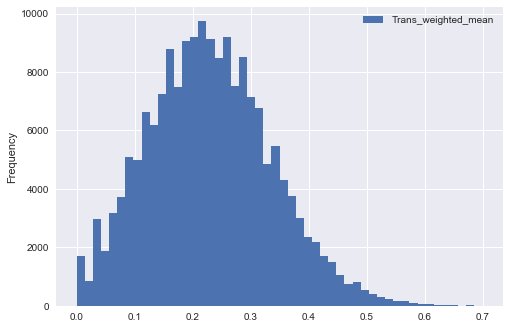

In [41]:
reviews_df_sm.plot(y = 'Trans_weighted_mean', kind = 'hist', bins = 50, logx=False)

1.0


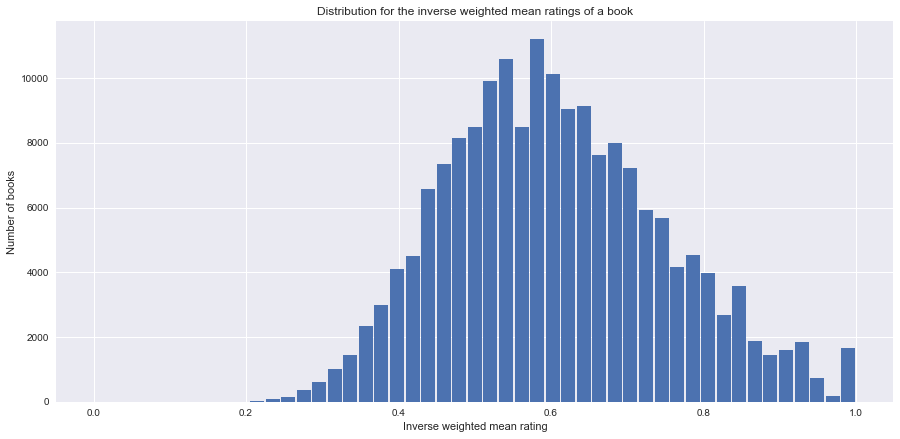

In [42]:
print(reviews_df_sm.Inverse_weighted_mean.max())
#Plot a histogram 
fig, ax = plt.subplots(figsize=(15,7), ncols=1, nrows=1)

reviews_df_sm.Inverse_weighted_mean.hist(bins=np.linspace(0,1,50), rwidth=0.9)




plt.title('Distribution for the inverse weighted mean ratings of a book')
plt.xlabel('Inverse weighted mean rating')
plt.ylabel('Number of books')

Now the graphs look way better. We can then refine our definitions for "good", "bad" and also add "neutral" books as following:

* "bad" book = the books in the 25% on the left of this plot
* "neutral" book = the books in the 50% in the middle of this plot
* "good" book = the books in the 25% on the right of this plot

We will also analyse the standard deviation to define what is a "controversial" book. 

After those definitions are set, we can try to see if they would match with a sentimental analysis model like Vader: Vader can predict if a sentence is negative or positive and we could see if a review is negative and positive and compare this to the number of stars it is related to.

In [43]:
reviews_df_sm.Inverse_weighted_mean.describe()

count    179335.000000
mean          0.606311
std           0.144122
min           0.200000
25%           0.500000
50%           0.594595
75%           0.700000
max           1.000000
Name: Inverse_weighted_mean, dtype: float64

In [44]:
# Spark context shutdown
sc.stop()

NameError: name 'sc' is not defined

# Roadmap for the future
Our internal milestones up until the report are:

- Decide all models of grouping data into categories (negative/positive, fast/slow plateauing of review numbers, etc.)

- Decide parameters and thresholds for category definitions based on the data

- Enrich data by scraping Amazon for genres as extensively as possible

- Create necessary intermediate files containing formatted data, to speed up analysis and computing

- Find the best way to use VADER to analyze positivity and negativity of reviews

- Calculate correlations between popularity metrics and positive and negative reviews and ratings
  * With respect to time
  * By aggregation by category (good, bad, controversial)
  * By aggregation by genre and author

- If necessary, run analysis on the cluster

- Find the exact data story we want to tell (choose exact questions), make it compelling, and link it to social good

- Decide format of report

- Depending on report format, distribute tasks to individual group members

- Produce good, polished visualizations that tell the story

- Construct report into a coherent document

- Update readme according to progress

- Create a plan for presentation and poster creation

The enrichment of the data will be done using the **Amazon Scraper.ipynb** notebook, which contains a description of its function (please have a look).

In order to use VADER, we will have to decide how to apply its sentence-based logic to entire reviews. The obvious way is to analyze each sentence and take the mean score, but we will look into whether this is the most sensible way or if another way would be more relevant.

In the future, these and many more notebook cells will be filled:

In [45]:
# Retrieve sentiments of reviews:
# TODO...

In [46]:
# Calculate correlations:
# TODO...

In [47]:
# Produce final visualizations:
# TODO...

# Vader Analysis 

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline

In [7]:
# Read the files and create a dataframe grouped by books 

df = pd.read_csv('data/sentiment_01.csv')

In [8]:
df.shape

(999999, 12)

In [9]:
by_book = df.groupby(['asin']).mean()
by_book.head()

,overall,rew_compound,rew_neg,rew_neu,rew_pos,summ_compound,summ_neg,summ_neu,summ_pos
asin,,,,,,,,,
000100039X,4.674757,0.778295,0.030427,0.775301,0.194252,0.277660,0.012772,0.649024,0.338209
0001055178,3.555556,0.215511,0.085778,0.808722,0.105556,-0.012039,0.076000,0.881444,0.042556
0001473123,4.625000,0.762069,0.015000,0.728313,0.256625,0.175725,0.014875,0.726688,0.258437
0001473727,5.000000,0.706571,0.018714,0.743286,0.237857,0.171843,0.022429,0.833429,0.144143
0001473905,4.666667,0.724667,0.019333,0.843667,0.137000,0.150833,0.000000,0.819667,0.180333


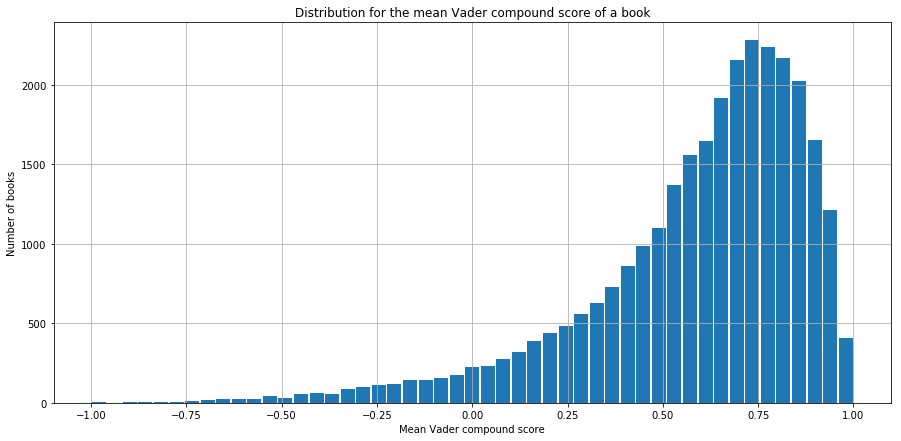

In [10]:
#Plot a histogram 
fig, ax = plt.subplots(figsize=(15,7), ncols=1, nrows=1)

by_book.rew_compound.hist(bins=np.linspace(-1,1,50), rwidth=0.9)




plt.title('Distribution for the mean Vader compound score of a book')
plt.xlabel('Mean Vader compound score')
plt.ylabel('Number of books')
#plt.xticks([1,2,3,4,5])

It looks like the same skewness (as we had with the reviews ratings before) in the positivness of the comments can be seen with the Vader analysis. Let's check if it is the case for the other files as well

In [11]:
def plot_histo (x):  
    df = pd.read_csv('data/sentiment_0'+str(x)+'.csv')
    by_book = df.groupby(['asin']).mean()


    #Plot a histogram 
    fig, ax = plt.subplots(figsize=(15,7), ncols=1, nrows=1)

    by_book.rew_compound.hist(bins=np.linspace(-1,1,50), rwidth=0.9)


    plt.title('Distribution for the mean Vader compound score of a book')
    plt.xlabel('Mean Vader compound score')
    plt.ylabel('Number of books')
    #plt.xticks([1,2,3,4,5])

In [12]:
#Put everything together in one dataframe

def create_dataf () : 
    df = pd.read_csv('data/sentiment_01.csv')
    total_df = df.groupby(['asin']).mean()
    for x in range(2,10):
        df = pd.read_csv('data/sentiment_0'+str(x)+'.csv')
        by_book = df.groupby(['asin']).mean()
        tot = total_df.copy()
        total_df = pd.concat([tot, by_book]) 
    return(total_df)


In [13]:
total_df = create_dataf()

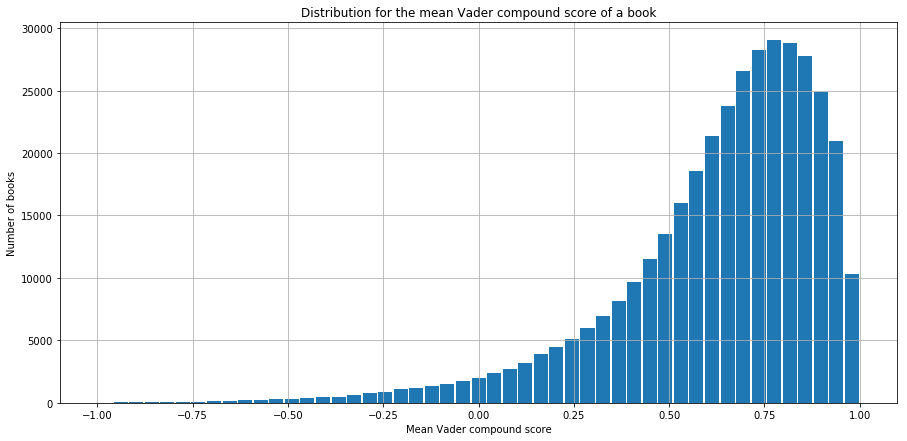

In [14]:
#Plot a histogram 
fig, ax = plt.subplots(figsize=(15,7), ncols=1, nrows=1)

total_df.rew_compound.hist(bins=np.linspace(-1,1,50), rwidth=0.9)


plt.title('Distribution for the mean Vader compound score of a book')
plt.xlabel('Mean Vader compound score')
plt.ylabel('Number of books')
#plt.xticks([1,2,3,4,5])

Taking all the comments we have and putting them into the vader programm and then plotting the mean of the compound score for each book gives a very similar plot (left skewed) to the one we drew before with the number of 1,2,3,4 and 5 stars for each book. 

Let's now try to compare the value for the compound score to the ratings score we normalized before. 

In [15]:
#recall the first table we got with the ratings
reviews_df_2.head()

NameError: name 'reviews_df_2' is not defined

In [ ]:
total_df['asin'] = total_df.index


In [ ]:
total_df.head()

In [ ]:
compare_df = pd.merge(reviews_df_2, total_df, how='inner', on=['asin'])

In [ ]:
#calculate the values of ratings to be between -1 and 1 
compare_df['norm_mean'] = ((1- (-1))/(5-1))*(compare_df.mean_rat-5)+1

In [ ]:
#compare the difference between ratings and vader 
compare_df['comparison'] = compare_df.norm_mean - compare_df.rew_compound

In [ ]:
#plot the difference
fig, ax = plt.subplots(figsize=(15,7), ncols=1, nrows=1)

compare_df.comparison.hist(bins=np.linspace(-1,1,50), rwidth=0.9)


plt.title('Distribution for the difference between the mean ratings and the mean of Vader compound score of books')
plt.xlabel('Mean ratings - mean Vader compound score')
plt.ylabel('Number of books')

This is a very good result as it shows that vader is very close to the ratings for a majority of cases as the plot is centered on 0 and the two right and left parts are very small quite fast. This means that the Vader model is consistent with the ratings we have for our comments and associate "positive" comments to high rated comments and "negative" comments to low rated comments.

# Time analysis

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline

In [2]:
df0 = pd.read_csv('data/sentiment_01.csv')

In [3]:
del df0['rew_neg']
del df0['rew_neu']
del df0['rew_pos']
del df0['summ_neg']
del df0['summ_compound']
del df0['summ_neu']
del df0['summ_pos']

In [4]:
df0.head()

,asin,unixReviewTime,reviewerID,overall,rew_compound
0,000100039X,2012-12-16 01:00:00,A10000012B7CGYKOMPQ4L,5.0,0.7256
1,000100039X,2003-12-11 01:00:00,A2S166WSCFIFP5,5.0,0.8349
2,000100039X,2014-01-18 01:00:00,A1BM81XB4QHOA3,5.0,0.4404
3,000100039X,2011-09-27 02:00:00,A1MOSTXNIO5MPJ,5.0,0.9201
4,000100039X,2002-10-07 02:00:00,A2XQ5LZHTD4AFT,5.0,0.9800


In this table, the asin is the Amazon code for a special book. Each line correspond to a review where the asin is the book reviewed, the unixReviewTime is the time at which the comment was posted, the reviewerID is the ID of the reviewer, the overall score is the rating given by the user with the comment and the rew_compound is the Vader score calculated by inputting the review in the Vader sentimental analysis algorithm. 

In [8]:
def create_tot_dataf () : 
    df0 = pd.read_csv('data/sentiment_01.csv')
    #transform the time to a time easily handled with pandas
    df0.index = df0.unixReviewTime.astype('datetime64[ns]')
    #delete the columns not needed
    del df0['rew_neg']
    del df0['rew_neu']
    del df0['rew_pos']
    del df0['summ_neg']
    del df0['summ_compound']
    del df0['summ_neu']
    del df0['summ_pos']
    total_df = df0
    for x in range(2,10):
        df0 = pd.read_csv('data/sentiment_0'+str(x)+'.csv')
        df0.index = df0.unixReviewTime.astype('datetime64[ns]')
        del df0['rew_neg']
        del df0['rew_neu']
        del df0['rew_pos']
        del df0['summ_neg']
        del df0['summ_compound']
        del df0['summ_neu']
        del df0['summ_pos']
        tot = total_df.copy()
        total_df = pd.concat([tot, df0])
    return(total_df)

In [99]:
#create a table with all information
tot_df = create_tot_dataf()
tot_df.head()

,asin,unixReviewTime,reviewerID,overall,rew_compound
unixReviewTime,,,,,
2012-12-16 01:00:00,000100039X,2012-12-16 01:00:00,A10000012B7CGYKOMPQ4L,5.0,0.7256
2003-12-11 01:00:00,000100039X,2003-12-11 01:00:00,A2S166WSCFIFP5,5.0,0.8349
2014-01-18 01:00:00,000100039X,2014-01-18 01:00:00,A1BM81XB4QHOA3,5.0,0.4404
2011-09-27 02:00:00,000100039X,2011-09-27 02:00:00,A1MOSTXNIO5MPJ,5.0,0.9201
2002-10-07 02:00:00,000100039X,2002-10-07 02:00:00,A2XQ5LZHTD4AFT,5.0,0.9800


In [100]:
#Groupe by month and take the mean rating and mean vader compound score of reviews 
tot_df_m = tot_df.groupby(tot_df.index.to_period('M')).mean()
tot_df_m.head()

,overall,rew_compound
unixReviewTime,,
1996-05,4.000000,-0.815600
1996-06,1.000000,-0.894300
1996-08,5.000000,0.986800
1996-09,5.000000,0.973200
1996-11,3.666667,0.506483


In [101]:
#Before 2000 there are not many reviews so it's not very representative
tot_df_sh = tot_df_m.loc[tot_df_m.index>=2000]

In [95]:
tot_df_sh.head()

,overall,rew_compound
unixReviewTime,,
2000-01,4.134407,0.584301
2000-02,4.159174,0.577632
2000-03,4.201006,0.594153
2000-04,4.253019,0.600023
2000-05,4.237516,0.595398


In [107]:
#calculate the values of ratings to be between -1 and 1 
tot_df_sh['scaled_rat'] = ((1- (-1))/(5-1))*(tot_df_sh.overall-5)+1

C:\Users\Nathalie\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


(-1, 1)

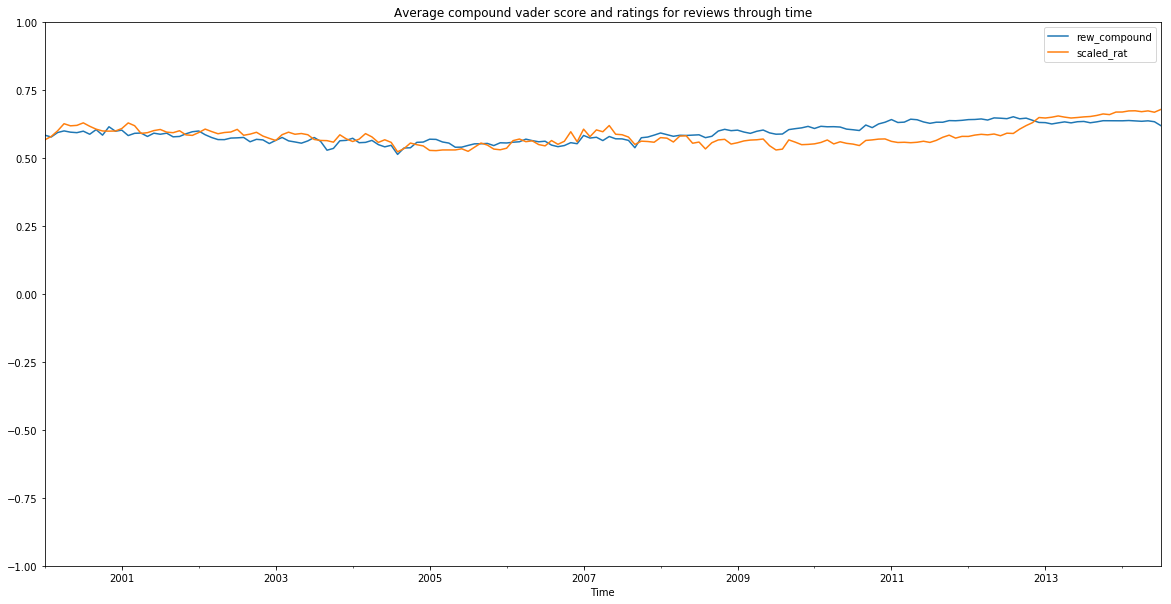

In [119]:
#show the vader compound score and scaled ratings evolution by month
tot_df_sh[['rew_compound','scaled_rat']].plot(figsize=(20,10))
plt.title("Average compound vader score and ratings for reviews through time")
plt.xlabel("Time")
plt.ylim(-1,1)

Again we see here that the compound score given by Vader is very close to the ratings associated with the review. We notice that in 2009 the two lines get further from each other: the compound score seems to get higher than the associated rating so people would have commented more positively than the number of stars they put with their comment. In 2013, the compound line gets lower again. 

In [124]:
#focus on number of reviews per month through years 
number_of_reviews_df = tot_df.groupby([tot_df.index.map(lambda t: t.year),tot_df.index.map(lambda t: t.month)]).count()[['asin']]

In [125]:
number_of_reviews_df.index.names = ['year','month']
number_of_reviews_df.head()

asin
year month      
1996 5         1
     6         1
     8         1
     9         1
     11        6

In [126]:
number_of_reviews_df = number_of_reviews_df.unstack(level = 0)

In [127]:
#divide by total number of reviews per year for each year
nbr_of_reviews_df = number_of_reviews_df / number_of_reviews_df.sum(axis = 0)

In [128]:
nbr_of_reviews_df.columns = number_of_reviews_df.columns.droplevel(level=0)

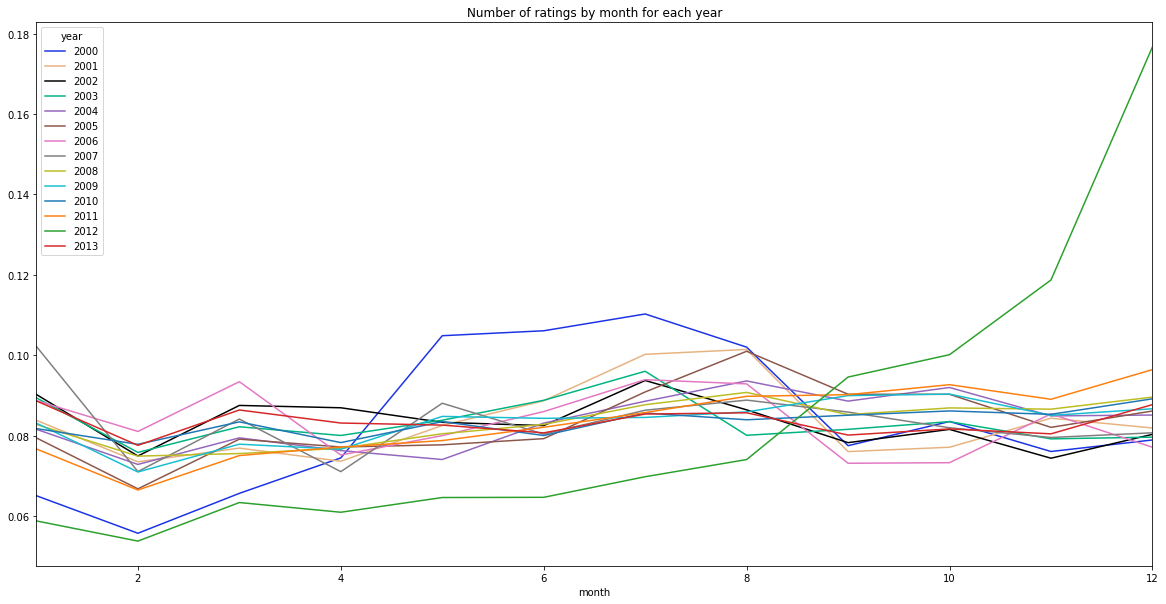

In [147]:
#we don't account for the first years where we don't have many reviews and the last year 2014 that is not complete
nbr_of_reviews_df.iloc[:, 4:-1].plot(figsize=(20,10))
plt.title("Number of ratings by month for each year")

#fix the 10 colors problem (only 10 colors available for more than 10 lines)
ax = plt.gca()
leg = ax.get_legend()
hl_dict = {handle.get_label(): handle for handle in leg.legendHandles}
hl_dict['2000'].set_color((0.1, 0.2, 0.9))
ax.get_lines()[0].set_color((0.1, 0.2, 0.9))
hl_dict['2001'].set_color((0.9, 0.7, 0.5))
ax.get_lines()[1].set_color((0.9, 0.7, 0.5))
hl_dict['2002'].set_color('black')
ax.get_lines()[2].set_color("black")
hl_dict['2003'].set_color((0.0, 0.7, 0.5))
ax.get_lines()[3].set_color((0.0, 0.7, 0.5))

The line for 2012 shows again that something happened to the Amazon website this year. The other lines show a pattern for the number of reviews each month: a drop can be seen in February which can be explained by the fact that people get books for christmas and review them around January and then in February nothing special happens. An increase can be seen also between april and august where people are in holiday so they have more time to read and review the books.

In [196]:
#focus on mean rating and mean vader compound through years
grouped_df = tot_df.groupby([tot_df.index.map(lambda t: t.year),tot_df.index.map(lambda t: t.month)]).mean()
grouped_df.head()

overall  rew_compound
unixReviewTime unixReviewTime                        
1996           5               4.000000     -0.815600
               6               1.000000     -0.894300
               8               5.000000      0.986800
               9               5.000000      0.973200
               11              3.666667      0.506483

In [199]:
mean_rats  = grouped_df [['overall']]
mean_rats = mean_rats.unstack(level = 0)
mean_rats.columns = mean_rats.columns.droplevel(level=0)
mean_comp = grouped_df[['rew_compound']]
mean_comp = mean_comp.unstack(level = 0)
mean_comp.columns = mean_comp.columns.droplevel(level=0)


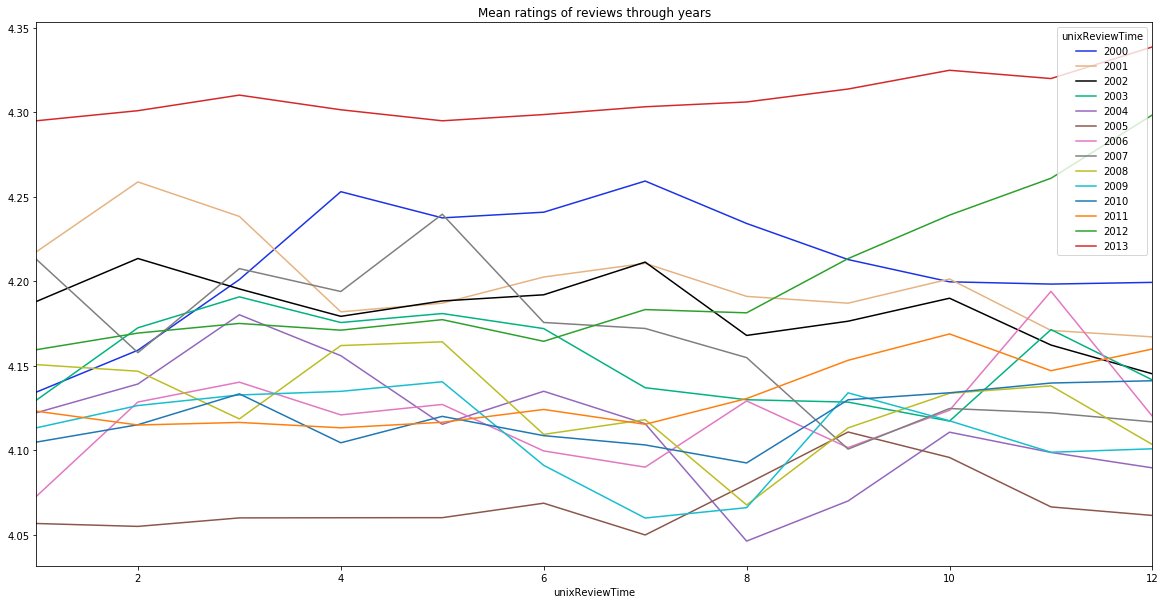

In [202]:
#we don't account for the first years where we don't have many reviews and the last year 2014 that is not complete
mean_rats.iloc[:, 4:-1].plot(figsize = (20,10))
plt.title("Mean ratings of reviews through years")

#fix the 10 colors problem (only 10 colors available for more than 10 lines)
ax = plt.gca()
leg = ax.get_legend()
hl_dict = {handle.get_label(): handle for handle in leg.legendHandles}
hl_dict['2000'].set_color((0.1, 0.2, 0.9))
ax.get_lines()[0].set_color((0.1, 0.2, 0.9))
hl_dict['2001'].set_color((0.9, 0.7, 0.5))
ax.get_lines()[1].set_color((0.9, 0.7, 0.5))
hl_dict['2002'].set_color('black')
ax.get_lines()[2].set_color("black")
hl_dict['2003'].set_color((0.0, 0.7, 0.5))
ax.get_lines()[3].set_color((0.0, 0.7, 0.5))

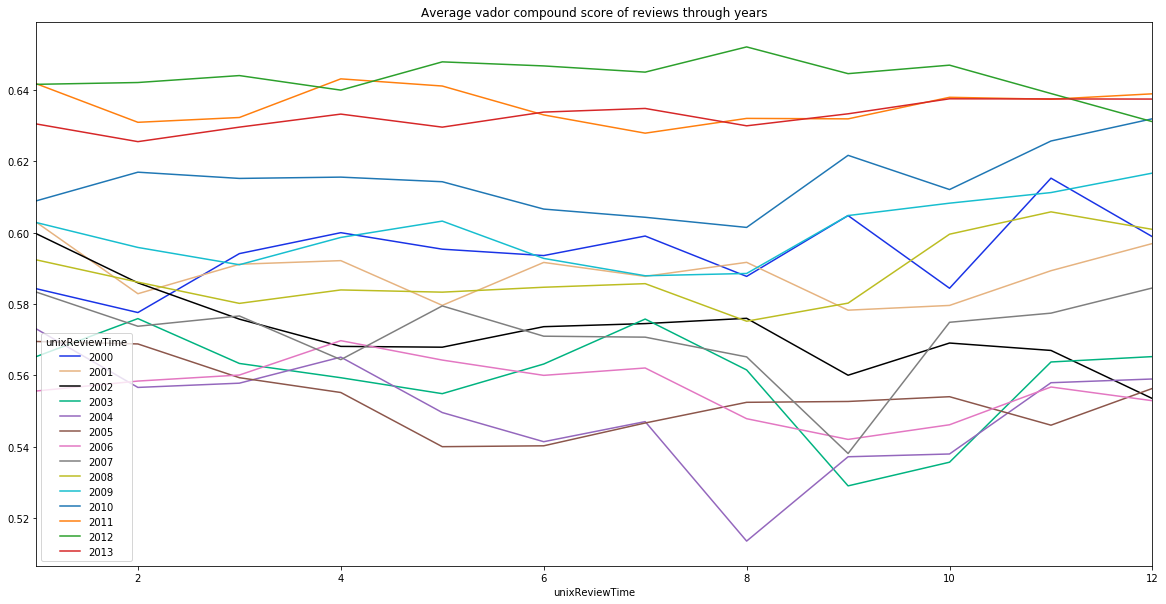

In [204]:
mean_comp.iloc[:, 4:-1].plot(figsize = (20,10))
plt.title("Average vador compound score of reviews through years")

#fix the 10 colors problem (only 10 colors available for more than 10 lines)
ax = plt.gca()
leg = ax.get_legend()
hl_dict = {handle.get_label(): handle for handle in leg.legendHandles}
hl_dict['2000'].set_color((0.1, 0.2, 0.9))
ax.get_lines()[0].set_color((0.1, 0.2, 0.9))
hl_dict['2001'].set_color((0.9, 0.7, 0.5))
ax.get_lines()[1].set_color((0.9, 0.7, 0.5))
hl_dict['2002'].set_color('black')
ax.get_lines()[2].set_color("black")
hl_dict['2003'].set_color((0.0, 0.7, 0.5))
ax.get_lines()[3].set_color((0.0, 0.7, 0.5))

With the first plot, we can clearly see that the mean rating of reviews went up from 2005 to 2013. This is less evident in the vader compound score comparison between years. 

# Analysis with books classification

In [163]:
categ_df = pd.read_csv('classifications.csv')

In [164]:
categ_df.head()

,asin,1,2,3,4,5,total,mean,median,std_dev,controversiality,goodness
0,000100039X,6,4,8,15,173,206,4.674757,5.0,0.873584,neutral,good
1,0001055178,0,4,2,10,2,18,3.555556,4.0,0.955814,neutral,bad
2,0001473123,1,0,0,2,13,16,4.625000,5.0,0.992157,neutral,good
3,0001473727,0,0,0,0,7,7,5.000000,5.0,0.000000,none,none
4,0001473905,0,0,1,0,5,6,4.666667,5.0,0.745356,none,none


In [205]:
#Create a big dataframe with a lot of information about the review and the book associated
entire_df = tot_df.merge(categ_df, on='asin', how='left')
entire_df.index = entire_df.unixReviewTime.astype('datetime64[ns]')
del entire_df['unixReviewTime']

In [206]:
entire_df.head()

,asin,reviewerID,overall,rew_compound,1,2,3,4,5,total,mean,median,std_dev,controversiality,goodness
unixReviewTime,,,,,,,,,,,,,,,
2012-12-16 01:00:00,000100039X,A10000012B7CGYKOMPQ4L,5.0,0.7256,6,4,8,15,173,206,4.674757,5.0,0.873584,neutral,good
2003-12-11 01:00:00,000100039X,A2S166WSCFIFP5,5.0,0.8349,6,4,8,15,173,206,4.674757,5.0,0.873584,neutral,good
2014-01-18 01:00:00,000100039X,A1BM81XB4QHOA3,5.0,0.4404,6,4,8,15,173,206,4.674757,5.0,0.873584,neutral,good
2011-09-27 02:00:00,000100039X,A1MOSTXNIO5MPJ,5.0,0.9201,6,4,8,15,173,206,4.674757,5.0,0.873584,neutral,good
2002-10-07 02:00:00,000100039X,A2XQ5LZHTD4AFT,5.0,0.9800,6,4,8,15,173,206,4.674757,5.0,0.873584,neutral,good


With this table, one needs to be careful since some columns correspond only to the book and other corresponds to the review. Each line corresponds to one review where the asin is the book reviewed, the unixreviextime is still the time of the review, the overall score is the rating given along with the review, the rew compound is the vader score calculated and all the columns after are only about the book. The 1,2,3,4 and 5 columns give the number of n-stars reviews under the book, the total score gives the total number of reviews under this book, the mean median and std_dev are for the n-star reviews and the controversiality and goodness scores are following our previous classification for books. 

In [207]:
review_df = entire_df.copy()
del review_df['1']
del review_df['2']
del review_df['3']
del review_df['4']
del review_df['5']
del review_df['median']
del review_df['std_dev']
del review_df['total']
del review_df['mean']

In [208]:
review_df.head()

,asin,reviewerID,overall,rew_compound,controversiality,goodness
unixReviewTime,,,,,,
2012-12-16 01:00:00,000100039X,A10000012B7CGYKOMPQ4L,5.0,0.7256,neutral,good
2003-12-11 01:00:00,000100039X,A2S166WSCFIFP5,5.0,0.8349,neutral,good
2014-01-18 01:00:00,000100039X,A1BM81XB4QHOA3,5.0,0.4404,neutral,good
2011-09-27 02:00:00,000100039X,A1MOSTXNIO5MPJ,5.0,0.9201,neutral,good
2002-10-07 02:00:00,000100039X,A2XQ5LZHTD4AFT,5.0,0.9800,neutral,good


In [209]:
good_df = review_df.loc[review_df.goodness == 'good']
Ngood = good_df.shape[0]
good_df.head()

,asin,reviewerID,overall,rew_compound,controversiality,goodness
unixReviewTime,,,,,,
2012-12-16 01:00:00,000100039X,A10000012B7CGYKOMPQ4L,5.0,0.7256,neutral,good
2003-12-11 01:00:00,000100039X,A2S166WSCFIFP5,5.0,0.8349,neutral,good
2014-01-18 01:00:00,000100039X,A1BM81XB4QHOA3,5.0,0.4404,neutral,good
2011-09-27 02:00:00,000100039X,A1MOSTXNIO5MPJ,5.0,0.9201,neutral,good
2002-10-07 02:00:00,000100039X,A2XQ5LZHTD4AFT,5.0,0.9800,neutral,good


In [210]:
bad_df = review_df.loc[review_df.goodness == 'bad']
Nbad = bad_df.shape[0]
bad_df.head()

,asin,reviewerID,overall,rew_compound,controversiality,goodness
unixReviewTime,,,,,,
2001-04-24 02:00:00,0001055178,A3JD7EO66IBTO,3.0,-0.6455,neutral,bad
2000-02-13 01:00:00,0001055178,A177RENQJIMMR9,4.0,0.8508,neutral,bad
2008-09-03 02:00:00,0001055178,AI4MUD97FH6G2,2.0,-0.2579,neutral,bad
2002-03-14 01:00:00,0001055178,ATWVC3WQOZSFS,3.0,0.8779,neutral,bad
2010-08-08 02:00:00,0001055178,A3VIOCJZ22JZXT,5.0,0.9381,neutral,bad


In [211]:
neutral_df = review_df.loc[review_df.goodness == 'neutral']
Nneutral = neutral_df.shape[0]
contr_df = review_df.loc[review_df.controversiality == 'controversial']
Ncontr = contr_df.shape[0]
uncontr_df = review_df.loc[review_df.controversiality == 'uncontroversial']
Nuncontr = uncontr_df.shape[0]
neutrcontr_df = review_df.loc[review_df.controversiality == 'neutral']
Nneutrcontr = neutrcontr_df.shape[0]

Text(0,0.5,'Mean rating for books')

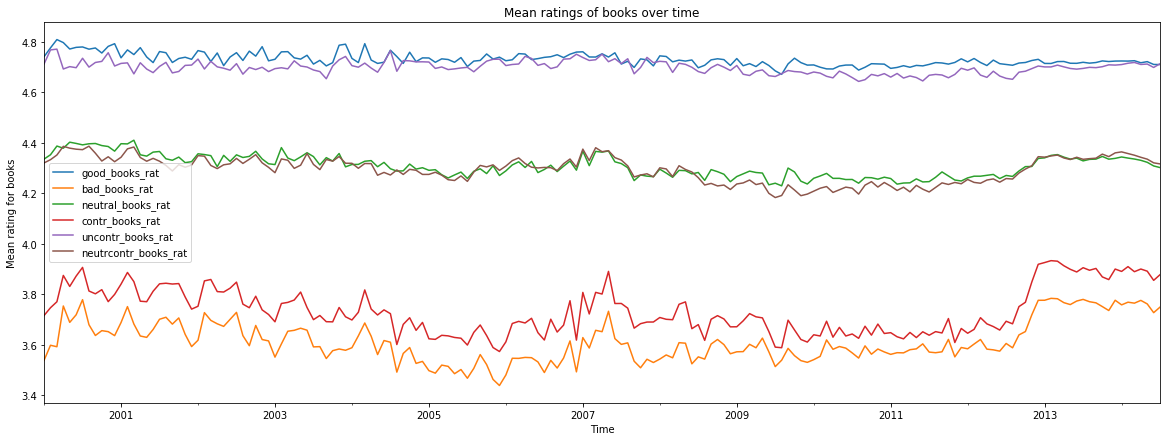

In [212]:
good_df_mean_m = good_df.groupby(good_df.index.to_period('M')).mean()
good_df_mean_m = good_df_mean_m.loc[ good_df_mean_m.index >= '2000']
bad_df_mean_m = bad_df.groupby(bad_df.index.to_period('M')).mean()
bad_df_mean_m = bad_df_mean_m.loc[ bad_df_mean_m.index >= '2000']
neutral_df_mean_m = neutral_df.groupby(neutral_df.index.to_period('M')).mean()
neutral_df_mean_m = neutral_df_mean_m.loc[ neutral_df_mean_m.index >= '2000']
contr_df_mean_m = contr_df.groupby(contr_df.index.to_period('M')).mean()
contr_df_mean_m = contr_df_mean_m.loc[ contr_df_mean_m.index >= '2000']
uncontr_df_mean_m = uncontr_df.groupby(uncontr_df.index.to_period('M')).mean()
uncontr_df_mean_m = uncontr_df_mean_m.loc[ uncontr_df_mean_m.index >= '2000']
neutrcontr_df_mean_m = neutrcontr_df.groupby(neutrcontr_df.index.to_period('M')).mean()
neutrcontr_df_mean_m = neutrcontr_df_mean_m.loc[ neutrcontr_df_mean_m.index >= '2000']

good_df_mean_m.columns = ['good_books_rat','good_books_comp']
bad_df_mean_m.columns = ['bad_books_rat','bad_books_comp']
neutral_df_mean_m.columns = ['neutral_books_rat','neutral_books_comp']
contr_df_mean_m.columns = ['contr_books_rat','contr_books_comp']
uncontr_df_mean_m.columns = ['uncontr_books_rat','uncontr_books_comp']
neutrcontr_df_mean_m.columns = ['neutrcontr_books_rat','neutrcontr_books_comp']

goodness_df_m = good_df_mean_m.join(bad_df_mean_m).join(neutral_df_mean_m).join(contr_df_mean_m).join(uncontr_df_mean_m).join(neutrcontr_df_mean_m)
goodness_df_m[['good_books_rat','bad_books_rat','neutral_books_rat','contr_books_rat','uncontr_books_rat','neutrcontr_books_rat']].plot(figsize=(20,7))
plt.title('Mean ratings of books over time')
plt.xlabel('Time')
plt.ylabel('Mean rating for books')

This shows again that most of the good books are uncontroversial ones and most of bad books are controversial ones as the lines are very close. What we also see is that good books and uncontroversial have a mean rating that is very high and very steady in time. However, the controversial books and the bad books have a mean rating that is not very steady, they are also controversial in time. 

Text(0,0.5,'Mean rating for books')

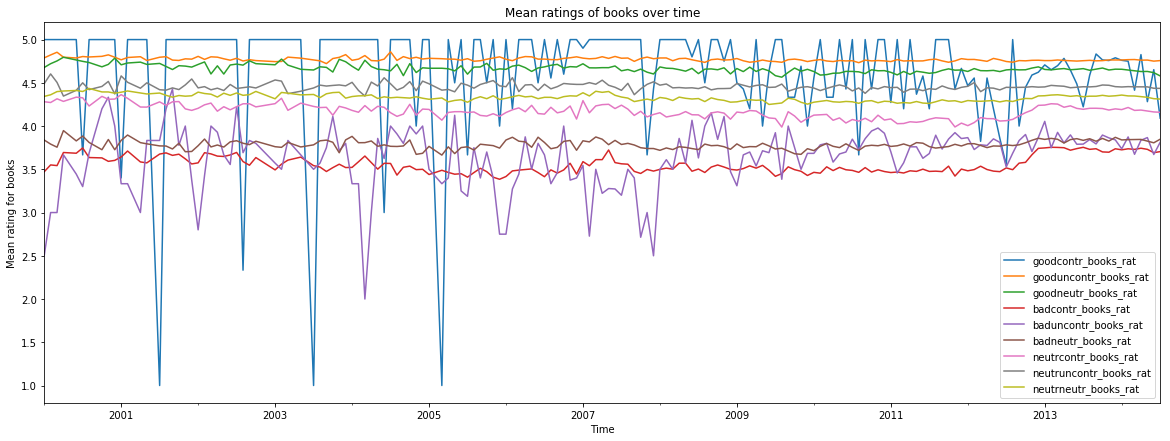

In [213]:
GC0 = good_df.loc[good_df.controversiality == 'controversial']
GC = GC0.groupby(GC0.index.to_period('M')).mean()
GC = GC.loc[ GC.index >= '2000']

GU0 = good_df.loc[good_df.controversiality == 'uncontroversial']
GU = GU0.groupby(GU0.index.to_period('M')).mean()
GU = GU.loc[ GU.index >= '2000']

GN0 = good_df.loc[good_df.controversiality == 'neutral']
GN = GN0.groupby(GN0.index.to_period('M')).mean()
GN = GN.loc[ GN.index >= '2000']

BC0 = bad_df.loc[bad_df.controversiality == 'controversial']
BC = BC0.groupby(BC0.index.to_period('M')).mean()
BC = BC.loc[ BC.index >= '2000']

BU0 = bad_df.loc[bad_df.controversiality == 'uncontroversial']
BU = BU0.groupby(BU0.index.to_period('M')).mean()
BU = BU.loc[ BU.index >= '2000']

BN0 = bad_df.loc[bad_df.controversiality == 'neutral']
BN = BN0.groupby(BN0.index.to_period('M')).mean()
BN = BN.loc[ BN.index >= '2000']

NC0 = neutral_df.loc[neutral_df.controversiality == 'controversial']
NC = NC0.groupby(NC0.index.to_period('M')).mean()
NC = NC.loc[ NC.index >= '2000']

NU0 = neutral_df.loc[neutral_df.controversiality == 'uncontroversial']
NU = NU0.groupby(NU0.index.to_period('M')).mean()
NU = NU.loc[ NU.index >= '2000']

NN0 = neutral_df.loc[neutral_df.controversiality == 'neutral']
NN = NN0.groupby(NN0.index.to_period('M')).mean()
NN = NN.loc[ NN.index >= '2000']

GC.columns = ['goodcontr_books_rat','goodcontr_books_comp']
GU.columns = ['gooduncontr_books_rat','gooduncontr_books_comp']
GN.columns = ['goodneutr_books_rat','goodneutr_books_comp']
BC.columns = ['badcontr_books_rat','badcontr_books_comp']
BU.columns = ['baduncontr_books_rat','baduncontr_books_comp']
BN.columns = ['badneutr_books_rat','badneutr_books_comp']
NC.columns = ['neutrcontr_books_rat','neutrcontr_books_comp']
NU.columns = ['neutruncontr_books_rat','neutruncontr_books_comp']
NN.columns = ['neutrneutr_books_rat','neutrneutr_books_comp']

goodness_df_m = GC.join(GU).join(GN).join(BC).join(BU).join(BN).join(NC).join(NU).join(NN)
goodness_df_m[['goodcontr_books_rat','gooduncontr_books_rat','goodneutr_books_rat',
               'badcontr_books_rat','baduncontr_books_rat','badneutr_books_rat',
               'neutrcontr_books_rat','neutruncontr_books_rat','neutrneutr_books_rat']].plot(figsize=(20,7))
plt.title('Mean ratings of books over time')
plt.xlabel('Time')
plt.ylabel('Mean rating for books')

The lines for good and controversial books and for bad and uncotnroversial books are way less smooth but that is because there are only a few books in those categories. However, we can still notice that their lines are varying more over time compared to the other categories. 

Text(0,0.5,'Number or reviews in the month')

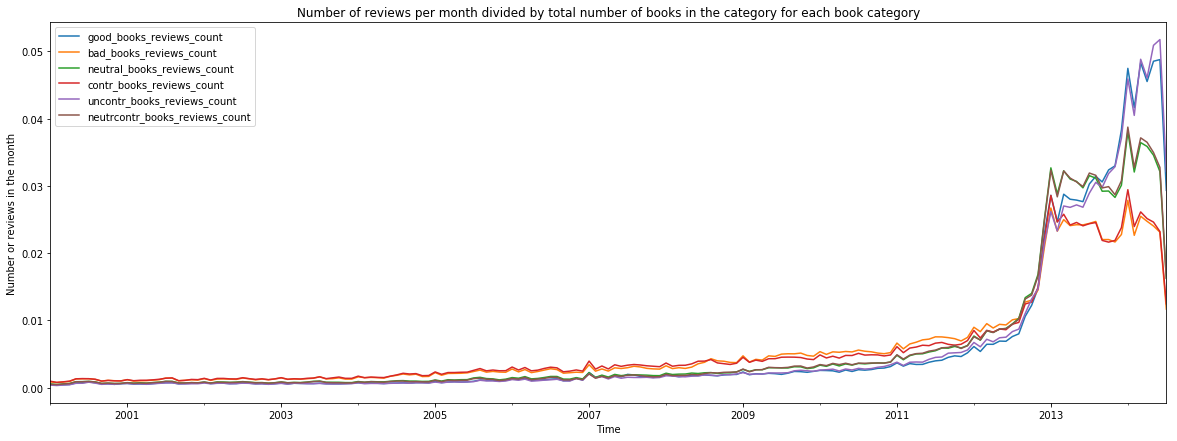

In [214]:
#number of comments with time 


good_df_count_m = good_df.groupby(good_df.index.to_period('M')).count()
good_df_count_m = good_df_count_m.loc[ good_df_count_m.index >= '2000'][['asin']]/Ngood
good_df_count_m.columns = ['good_books_reviews_count']

bad_df_count_m = bad_df.groupby(bad_df.index.to_period('M')).count()
bad_df_count_m = bad_df_count_m.loc[ bad_df_count_m.index >= '2000'][['asin']]/Nbad
bad_df_count_m.columns = ['bad_books_reviews_count']

neutral_df_count_m = neutral_df.groupby(neutral_df.index.to_period('M')).count()
neutral_df_count_m = neutral_df_count_m.loc[ neutral_df_count_m.index >= '2000'][['asin']]/Nneutral
neutral_df_count_m.columns = ['neutral_books_reviews_count']


contr_df_count_m = contr_df.groupby(contr_df.index.to_period('M')).count()
contr_df_count_m = contr_df_count_m.loc[ contr_df_count_m.index >= '2000'][['asin']]/Ncontr
contr_df_count_m.columns = ['contr_books_reviews_count']

uncontr_df_count_m = uncontr_df.groupby(uncontr_df.index.to_period('M')).count()
uncontr_df_count_m = uncontr_df_count_m.loc[ uncontr_df_count_m.index >= '2000'][['asin']]/Nuncontr
uncontr_df_count_m.columns = ['uncontr_books_reviews_count']

neutrcontr_df_count_m = neutrcontr_df.groupby(neutrcontr_df.index.to_period('M')).count()
neutrcontr_df_count_m = neutrcontr_df_count_m.loc[ neutrcontr_df_count_m.index >= '2000'][['asin']]/Nneutrcontr
neutrcontr_df_count_m.columns = ['neutrcontr_books_reviews_count']

goodness_df_count_m = good_df_count_m.join(bad_df_count_m).join(neutral_df_count_m).join(contr_df_count_m).join(uncontr_df_count_m).join(neutrcontr_df_count_m)

goodness_df_count_m.plot(figsize=(20,7))
plt.title('Number of reviews per month divided by total number of books in the category for each book category')
plt.xlabel('Time')
plt.ylabel('Number or reviews in the month')

Here we can see that the evolutions are very similar for all types of books, there is still something happening in 2012 in the Amazon website regarding reviews but it is a general pattern.

Text(0,0.5,'Number or reviews in the month')

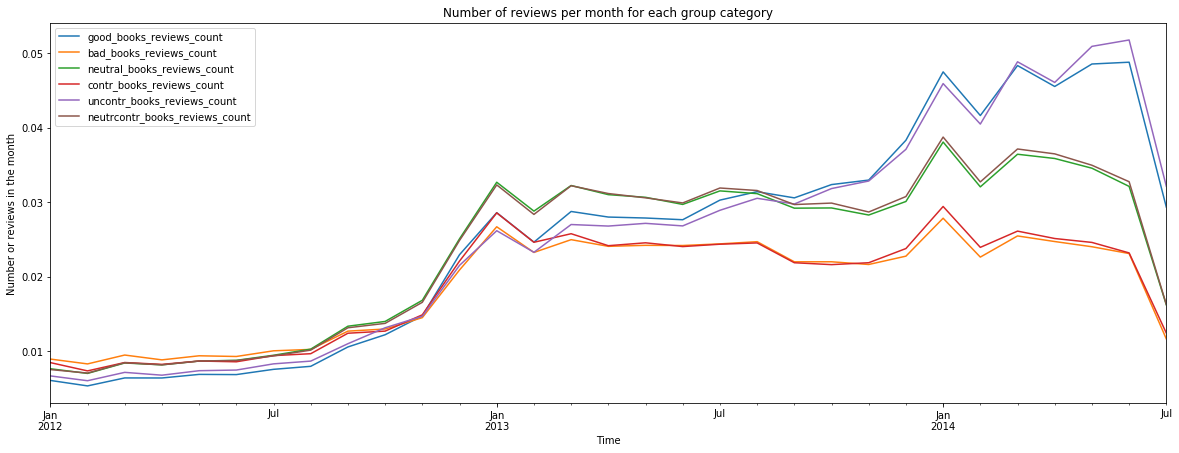

In [215]:
#number of comments with time 


good_df_count_m = good_df.groupby(good_df.index.to_period('M')).count()
good_df_count_m = good_df_count_m.loc[ good_df_count_m.index >= '2012'][['asin']]/Ngood
good_df_count_m.columns = ['good_books_reviews_count']

bad_df_count_m = bad_df.groupby(bad_df.index.to_period('M')).count()
bad_df_count_m = bad_df_count_m.loc[ bad_df_count_m.index >= '2012'][['asin']]/Nbad
bad_df_count_m.columns = ['bad_books_reviews_count']

neutral_df_count_m = neutral_df.groupby(neutral_df.index.to_period('M')).count()
neutral_df_count_m = neutral_df_count_m.loc[ neutral_df_count_m.index >= '2012'][['asin']]/Nneutral
neutral_df_count_m.columns = ['neutral_books_reviews_count']


contr_df_count_m = contr_df.groupby(contr_df.index.to_period('M')).count()
contr_df_count_m = contr_df_count_m.loc[ contr_df_count_m.index >= '2012'][['asin']]/Ncontr
contr_df_count_m.columns = ['contr_books_reviews_count']

uncontr_df_count_m = uncontr_df.groupby(uncontr_df.index.to_period('M')).count()
uncontr_df_count_m = uncontr_df_count_m.loc[ uncontr_df_count_m.index >= '2012'][['asin']]/Nuncontr
uncontr_df_count_m.columns = ['uncontr_books_reviews_count']

neutrcontr_df_count_m = neutrcontr_df.groupby(neutrcontr_df.index.to_period('M')).count()
neutrcontr_df_count_m = neutrcontr_df_count_m.loc[ neutrcontr_df_count_m.index >= '2012'][['asin']]/Nneutrcontr
neutrcontr_df_count_m.columns = ['neutrcontr_books_reviews_count']

goodness_df_count_m = good_df_count_m.join(bad_df_count_m).join(neutral_df_count_m).join(contr_df_count_m).join(uncontr_df_count_m).join(neutrcontr_df_count_m)

goodness_df_count_m.plot(figsize=(20,7))
plt.title('Number of reviews per month for each group category')
plt.xlabel('Time')
plt.ylabel('Number or reviews in the month')

Before Jan 2013, all the lines are very close which means that all types of books were commented the same. The increase in early 2014 was higher for the good books and uncontroversial books than for the other categories. 

In [216]:
#have a look at the outliers 

In [217]:
badcontr_df = bad_df.loc[bad_df.controversiality == "uncontroversial"]
baduncontr_df = bad_df.loc[bad_df.controversiality == "uncontroversial"]

In [218]:
goodcontr_df = good_df.loc[good_df.controversiality == "controversial"]

Text(0,0.5,'Number or reviews in the month')

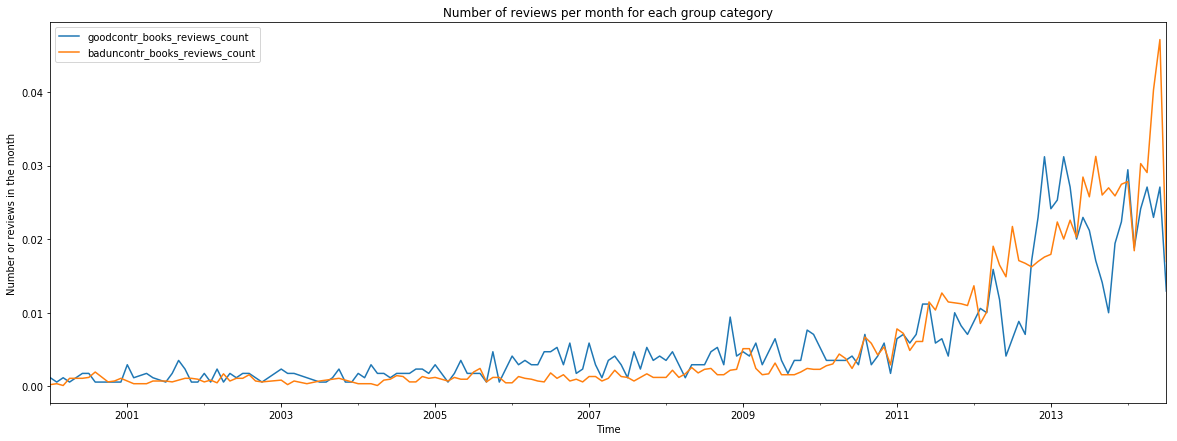

In [219]:
Ngoodcontr = goodcontr_df.shape[0]
Nbaduncontr = baduncontr_df.shape[0]
goodcontr_df_count_m = goodcontr_df.groupby(goodcontr_df.index.to_period('M')).count()
goodcontr_df_count_m = goodcontr_df_count_m.loc[ goodcontr_df_count_m.index >= '2000'][['asin']]/Ngoodcontr
goodcontr_df_count_m.columns = ['goodcontr_books_reviews_count']

baduncontr_df_count_m = baduncontr_df.groupby(baduncontr_df.index.to_period('M')).count()
baduncontr_df_count_m = baduncontr_df_count_m.loc[ baduncontr_df_count_m.index >= '2000'][['asin']]/Nbaduncontr
baduncontr_df_count_m.columns = ['baduncontr_books_reviews_count']


outliers_df_count_m = goodcontr_df_count_m.join(baduncontr_df_count_m)

outliers_df_count_m.plot(figsize=(20,7))
plt.title('Number of reviews per month for each group category')
plt.xlabel('Time')
plt.ylabel('Number or reviews in the month')

Here we see that the lines are way less smooth again this is because in those categories there are way fewer books. 

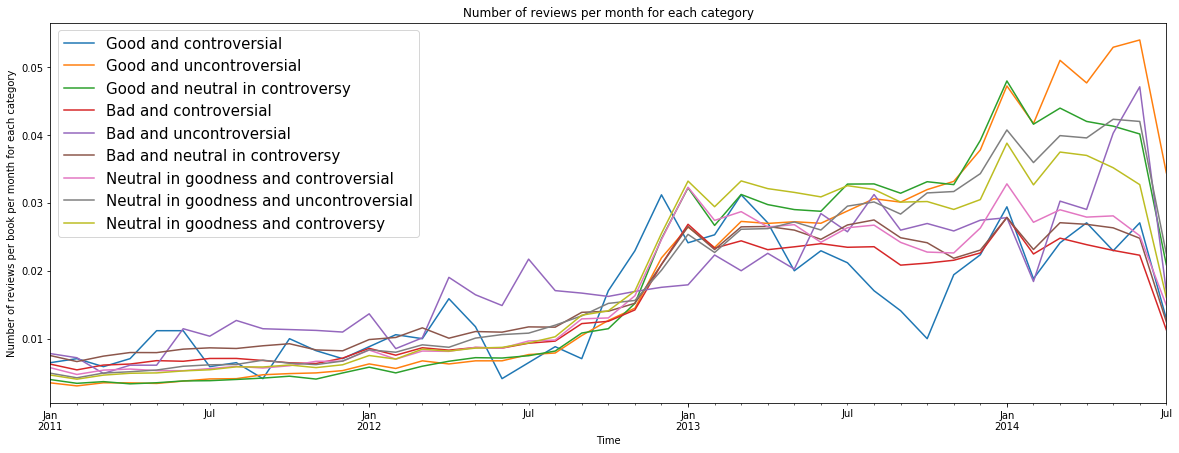

In [228]:
Ngc= GC0.shape[0]
GC = GC0.groupby(GC0.index.to_period('M')).count()
GC = GC.loc[ GC.index >= '2011'][['asin']]/Ngc
GC.columns = ['Good and controversial']

Ngu= GU0.shape[0]
GU = GU0.groupby(GU0.index.to_period('M')).count()
GU = GU.loc[ GU.index >= '2011'][['asin']]/Ngu
GU.columns =['Good and uncontroversial']

Ngn= GN0.shape[0]
GN = GN0.groupby(GN0.index.to_period('M')).count()
GN = GN.loc[ GN.index >= '2011'][['asin']]/Ngn
GN.columns = ['Good and neutral in controversy']

Nbc=BC0.shape[0]
BC = BC0.groupby(BC0.index.to_period('M')).count()
BC = BC.loc[ BC.index >= '2011'][['asin']]/Nbc
BC.columns = ['Bad and controversial']


Nbu=BU0.shape[0]
BU = BU0.groupby(BU0.index.to_period('M')).count()
BU = BU.loc[ BU.index >= '2011'][['asin']]/Nbu
BU.columns = ['Bad and uncontroversial']

Nbn = BN0.shape[0]
BN = BN0.groupby(BN0.index.to_period('M')).count()
BN = BN.loc[ BN.index >= '2011'][['asin']]/Nbn
BN.columns= ['Bad and neutral in controversy']

Nnc=NC0.shape[0]
NC = NC0.groupby(NC0.index.to_period('M')).count()
NC = NC.loc[ NC.index >= '2011'][['asin']]/Nnc
NC.columns = ['Neutral in goodness and controversial']

Nnu = NU0.shape[0]
NU = NU0.groupby(NU0.index.to_period('M')).count()
NU = NU.loc[ NU.index >= '2011'][['asin']]/Nnu
NU.columns = ['Neutral in goodness and uncontroversial']

Nnn=NN0.shape[0]
NN = NN0.groupby(NN0.index.to_period('M')).count()
NN = NN.loc[ NN.index >= '2011'][['asin']]/Nnn
NN.columns = ['Neutral in goodness and controversy']

goodness_df_m = GC.join(GU).join(GN).join(BC).join(BU).join(BN).join(NC).join(NU).join(NN)
goodness_df_m.plot(figsize=(20,7))
plt.title('Number of reviews per month for each category')
plt.xlabel('Time')
plt.ylabel('Number of reviews per book per month for each category')
plt.legend(prop={'size': 15})
plt.savefig('images/number_of_reviews_per_month_for_each_category.png', transparent=True)


Again, there is hardly any difference between the evolution in the number of reviews from 2011 to 2014 for the different categories. The blue line and purple one are less smooth given that there are less books in those categories.

In [221]:
#number of reviews per month for different number of stars 

In [42]:
review_df.head()

,asin,reviewerID,overall,rew_compound,controversiality,goodness
unixReviewTime,,,,,,
2012-12-16 01:00:00,000100039X,A10000012B7CGYKOMPQ4L,5.0,0.7256,neutral,good
2003-12-11 01:00:00,000100039X,A2S166WSCFIFP5,5.0,0.8349,neutral,good
2014-01-18 01:00:00,000100039X,A1BM81XB4QHOA3,5.0,0.4404,neutral,good
2011-09-27 02:00:00,000100039X,A1MOSTXNIO5MPJ,5.0,0.9201,neutral,good
2002-10-07 02:00:00,000100039X,A2XQ5LZHTD4AFT,5.0,0.9800,neutral,good


In [47]:
df_5 = review_df.loc[review_df.overall == 5]
N5= df_5.shape[0]
df_4 = review_df.loc[review_df.overall == 4]
N4= df_4.shape[0]
df_3 = review_df.loc[review_df.overall == 3]
N3= df_3.shape[0]
df_2 = review_df.loc[review_df.overall == 2]
N2= df_2.shape[0]
df_1 = review_df.loc[review_df.overall == 1]
N1= df_1.shape[0]

Text(0,0.5,'Number or reviews with n-stars in the month')

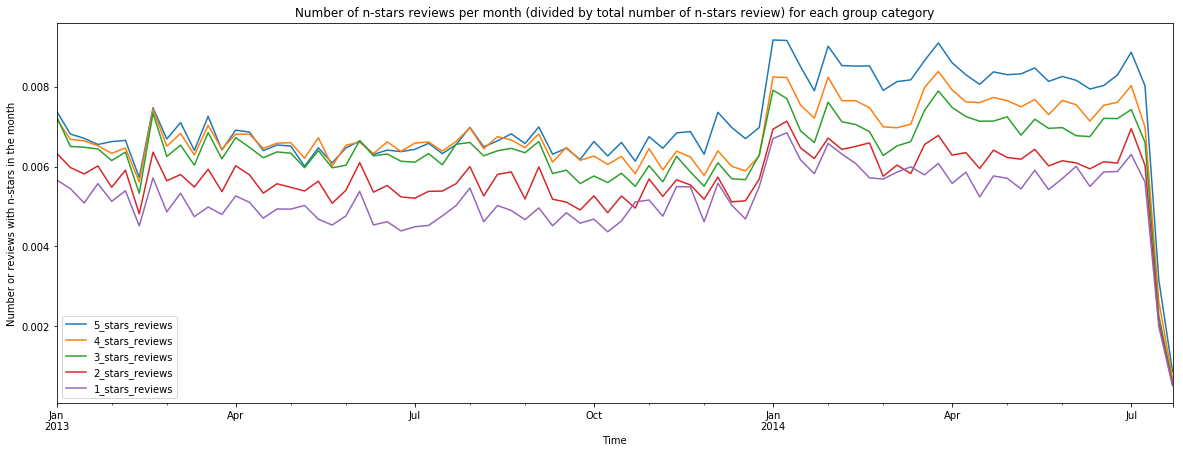

In [77]:
df_5_count_m = df_5.groupby(df_5.index.to_period('W')).count()
df_5_count_m = df_5_count_m.loc[ df_5_count_m.index >= '2013'][['asin']]/N5
df_4_count_m = df_4.groupby(df_4.index.to_period('W')).count()
df_4_count_m = df_4_count_m.loc[ df_4_count_m.index >= '2013'][['asin']]/N4
df_3_count_m = df_3.groupby(df_3.index.to_period('W')).count()
df_3_count_m = df_3_count_m.loc[ df_3_count_m.index >= '2013'][['asin']]/N3
df_2_count_m = df_2.groupby(df_2.index.to_period('W')).count()
df_2_count_m = df_2_count_m.loc[ df_2_count_m.index >= '2013'][['asin']]/N2
df_1_count_m = df_1.groupby(df_1.index.to_period('W')).count()
df_1_count_m = df_1_count_m.loc[ df_1_count_m.index >= '2013'][['asin']]/N1

df_5_count_m.columns=['5_stars_reviews']
df_4_count_m.columns=['4_stars_reviews']
df_3_count_m.columns=['3_stars_reviews']
df_2_count_m.columns=['2_stars_reviews']
df_1_count_m.columns=['1_stars_reviews']
stars_df_count_m = df_5_count_m.join(df_4_count_m).join(df_3_count_m).join(df_2_count_m).join(df_1_count_m)

stars_df_count_m.plot(figsize=(20,7))
plt.title('Number of n-stars reviews per month (divided by total number of n-stars review) for each group category')
plt.xlabel('Time')
plt.ylabel('Number or reviews with n-stars in the month')

The evolutions for all the 1,2,3,4 and 5 stars are very similar in time, there is no noticeable difference.